# Apprentissage supervisé

Le but de ce TP est d'implémenter et tester les algorithmes vues en classes.

## Utilitaire

Ci-dessous des fonctions à utiliser pour le TP.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


def plot_points(points, ax, color):
    """
        Plots points.
        :param points: the points to plot
        :type points: iterable
        :param ax: the axis to plot in
        :type ax: matplotlib.axis
        :param color: the plotted points color
        :type color: str
    """
    ax.scatter(points[:, 0], points[:, 1], c=color)

    
def plot_dataset(X, Y, ax, **parameters):
    """
        Plots the dataset.
        :param X: the points to plot
        :type X: np.array
        :param Y: the points classes
        :type Y: np.array
        :param ax: the axis to plot in
        :type ax: matplotlib.axis
        :param colors: the plotted points colors depending on the class
        :type colors: iterable
    """
    for x, color in zip([X[Y==y] for y in set(Y)], parameters['colors']):
        plot_points(x, ax, color)

        
def mesh_from(X, number=100):
    """
        Constructs mesh points from some 2D instances
        :param X: the 2D instances
        :type X: np.array
        :param number: the quatization frequency
        :type number: int
        :return: the mesh points
        :rtype: tuple
    """
    return np.meshgrid(
        np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, number),
        np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, number),
    )


def plot_separator(xx, yy, ax, classifier, **parameters):
    """
        Plots separator.
        
        :param xx: mesh first coordinates
        :type xx: np.array
        :param yy: mesh second coordinates
        :type yy: np.array
        :param ax: subplot to draw in
        :type ax: matplotlib.axis
        :param classifier: the prediction function
        :type classifier: callable
    """
    Z = classifier(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, **parameters)


On génère trois bases de données pour l'apprentissage:

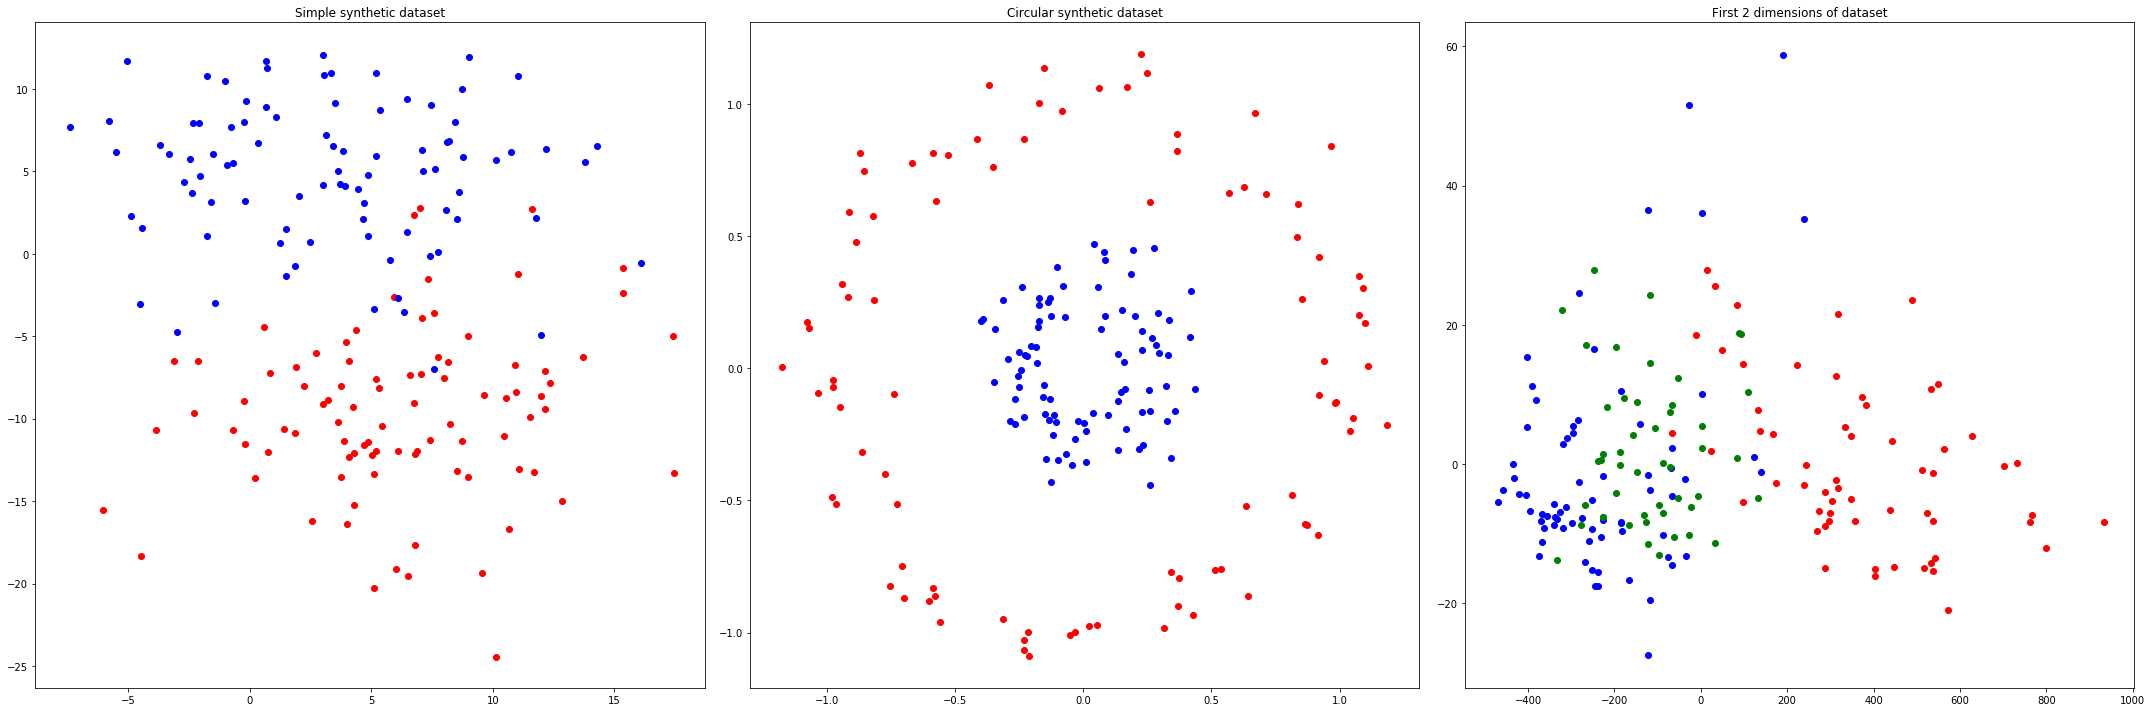

In [2]:
import sklearn.datasets
import sklearn.decomposition

X_blob, Y_blob = sklearn.datasets.make_blobs(n_samples=178, centers=2, random_state=10, cluster_std=5)
X_circles, Y_circles = sklearn.datasets.make_circles(n_samples=178, factor=.3, noise=.1)
wine_data = sklearn.datasets.load_wine()
X_wine, Y_wine = sklearn.decomposition.PCA(n_components=2).fit_transform(wine_data.data), wine_data.target
datasets = [('blobs', X_blob, Y_blob), ('circles', X_circles, Y_circles), ('wine', X_wine, Y_wine)]

figure, (ax1, ax2, ax3) = plt.subplots(1, 3)
figure.set_figheight(10)
figure.set_figwidth(30)

plot_dataset(X_blob, Y_blob, ax1, colors=['r', 'b'])
ax1.set_title('Simple synthetic dataset')
plot_dataset(X_circles, Y_circles, ax2, colors=['r', 'b'])
ax2.set_title('Circular synthetic dataset')
plot_dataset(X_wine, Y_wine, ax3, colors=['r', 'b', 'g'])
ax3.set_title('First 2 dimensions of dataset')
plt.tight_layout()
plt.show()


#### Commentaire

On présente trois bases de données:
* Le premier peut facilement être séparer par une droite;
* le deuxième peut être séparer par un cercle placé entre les deux amas;
* le troisième présente trois classes un peu confondues.

## Classifieur de centroïdes

1.
Implémenter la fonction `centroid_train` qui entraîne un modèle de classifieur de centroïdes.

2.
Implémenter le fonction `centroid_test` qui prédit, pour une instance, la classe la plus probable.

3.
Lancer le code et commenter les résultats.

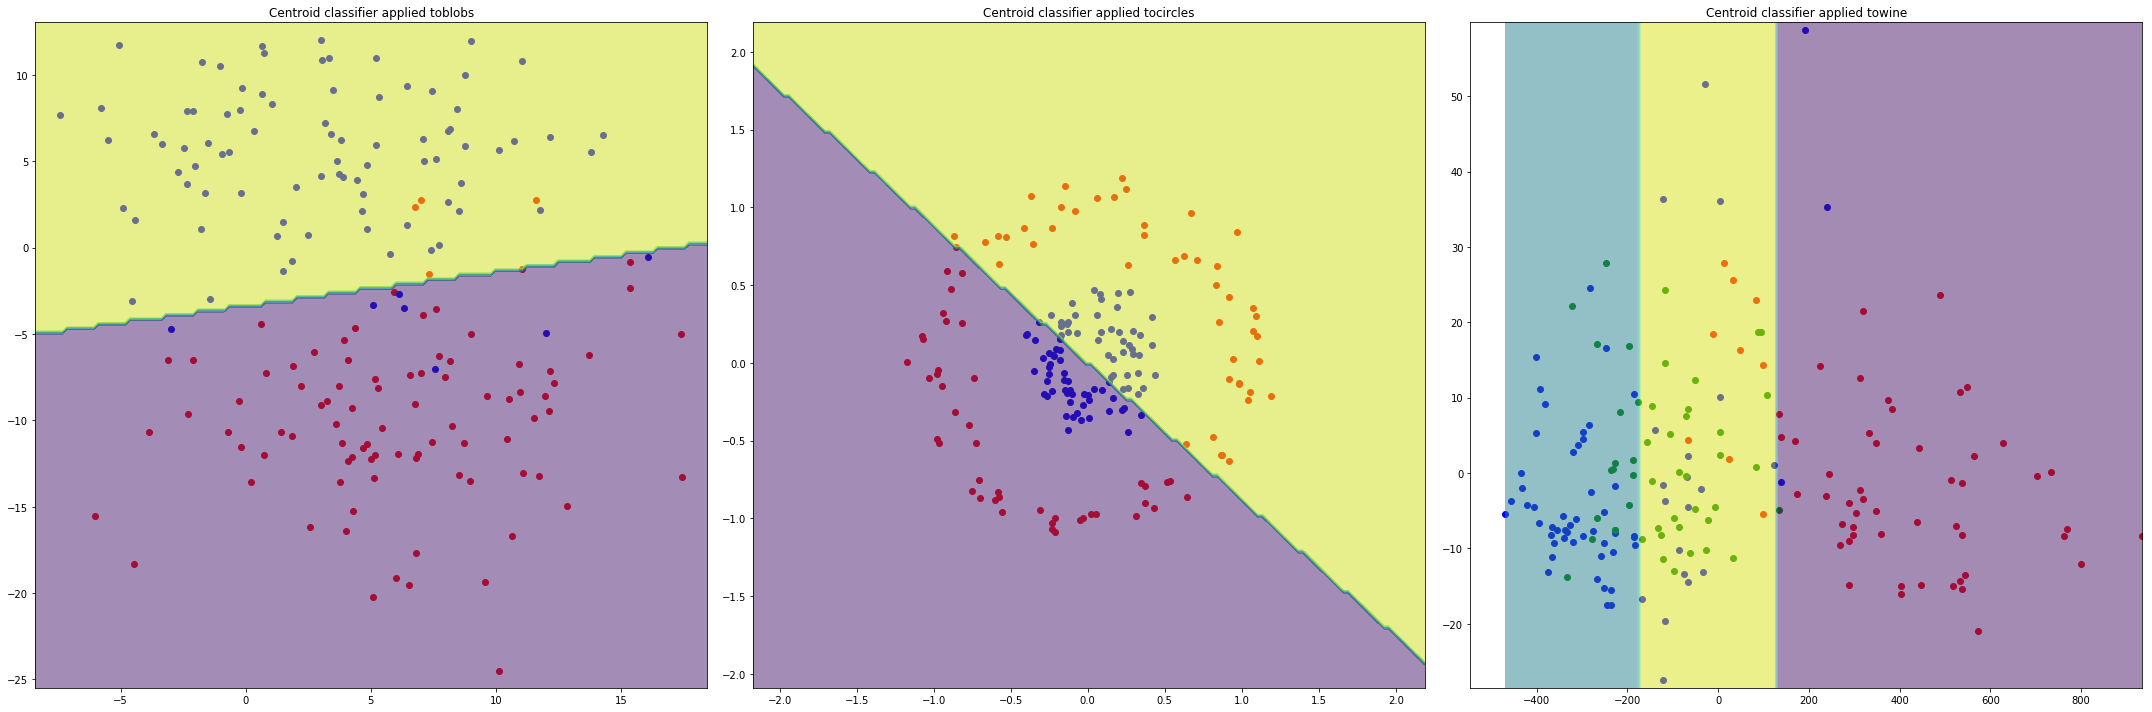

In [3]:
import operator

# Euclidian Norm
euclidian = lambda x, y: np.linalg.norm(np.array(x) - np.array(y))

def centroid_train(X, Y):
    return [
        (cls, np.mean(X[Y==cls], axis=0))
        # Implement this
        for cls in set(Y)
    ]


def centroid_test(X, centroids, metric=euclidian):
    return np.array(
        [
            min(
                [
                    (cls, metric(x, mean))
                    for cls, mean in centroids
                ],
                key=operator.itemgetter(-1)
            )[0]
            for x in X
        ]
    )


figure, axes = plt.subplots(1, 3)
figure.set_figheight(10)
figure.set_figwidth(30)

for (name, X, Y), ax, colors in zip(datasets, axes, [['r', 'b'], ['r', 'b'], ['r', 'b', 'g']]):
    plot_dataset(X, Y, ax, colors=colors)
    centroids = centroid_train(X, Y)
    xx, yy = mesh_from(X, 150)
    plot_separator(
        xx,
        yy,
        ax,
        lambda x:  centroid_test(x, centroids),
        cmap=plt.cm.viridis,
        alpha=0.5
    )
    ax.set_title('Centroid classifier applied to' + name)

plt.tight_layout()
plt.show()


#### Commentaire

Pour la base de données:
* 1: le classifieur correspond bien aux modèle de fonction de décision optimale (erreur de biais faible) avec des erreurs de variance sur les données d'entraînement (erreur de variance faible).
* 2: le classifieur ne correpond pas du tout au meilleur modèle de séparation (grande erreur de biais).
* 3: le classifieur n'arrive pas à bien approcher les séparateurs entre classes (grande erreur de biais).

## k-NN

4.
Utiliser la classe `KNeighborsClassifier` pour compléter le code suivant. Commenter les résultats.


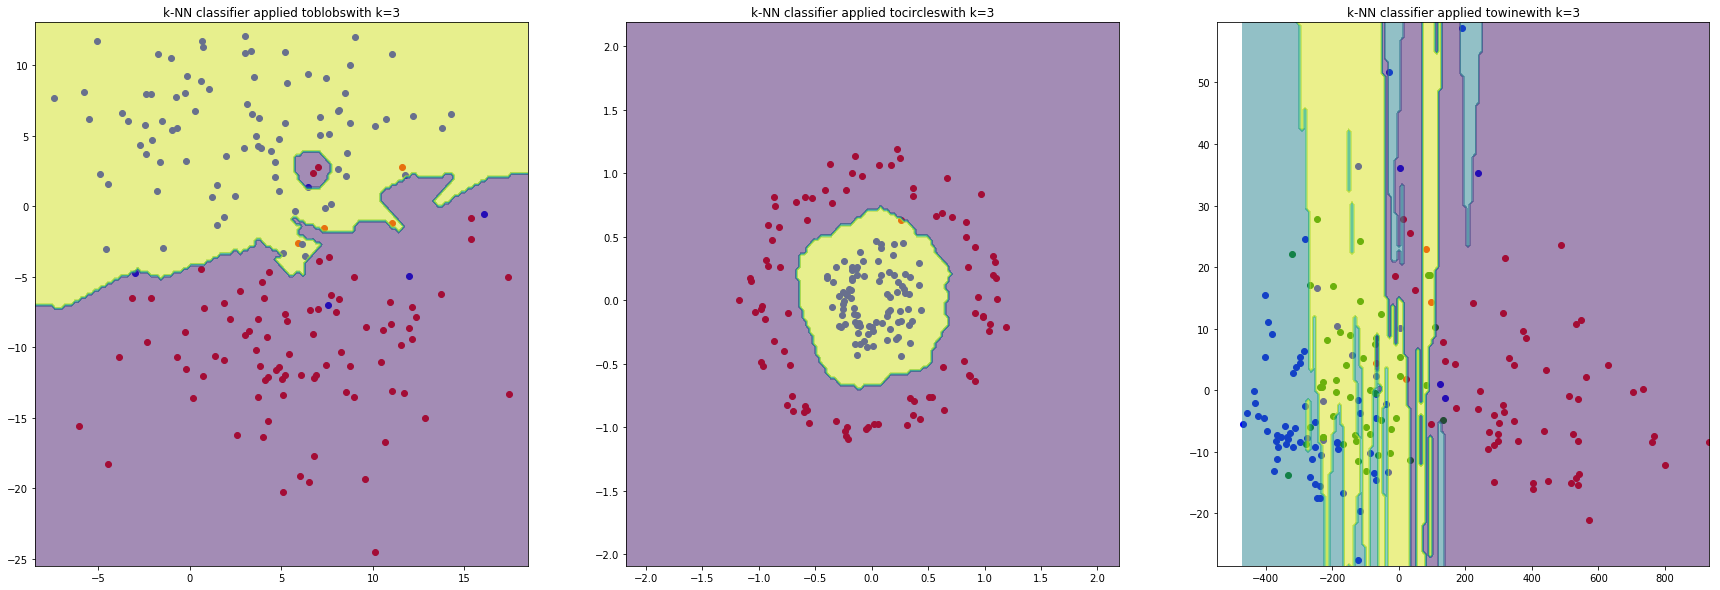

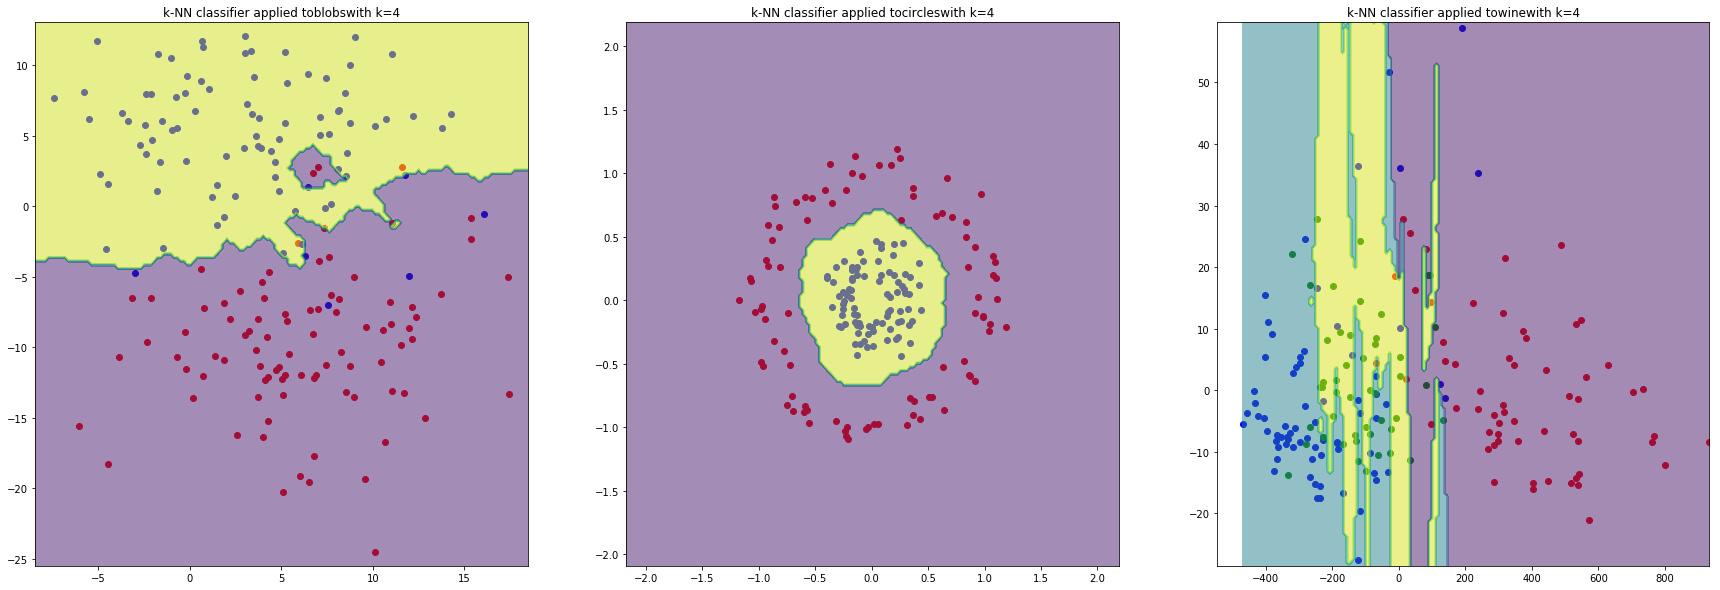

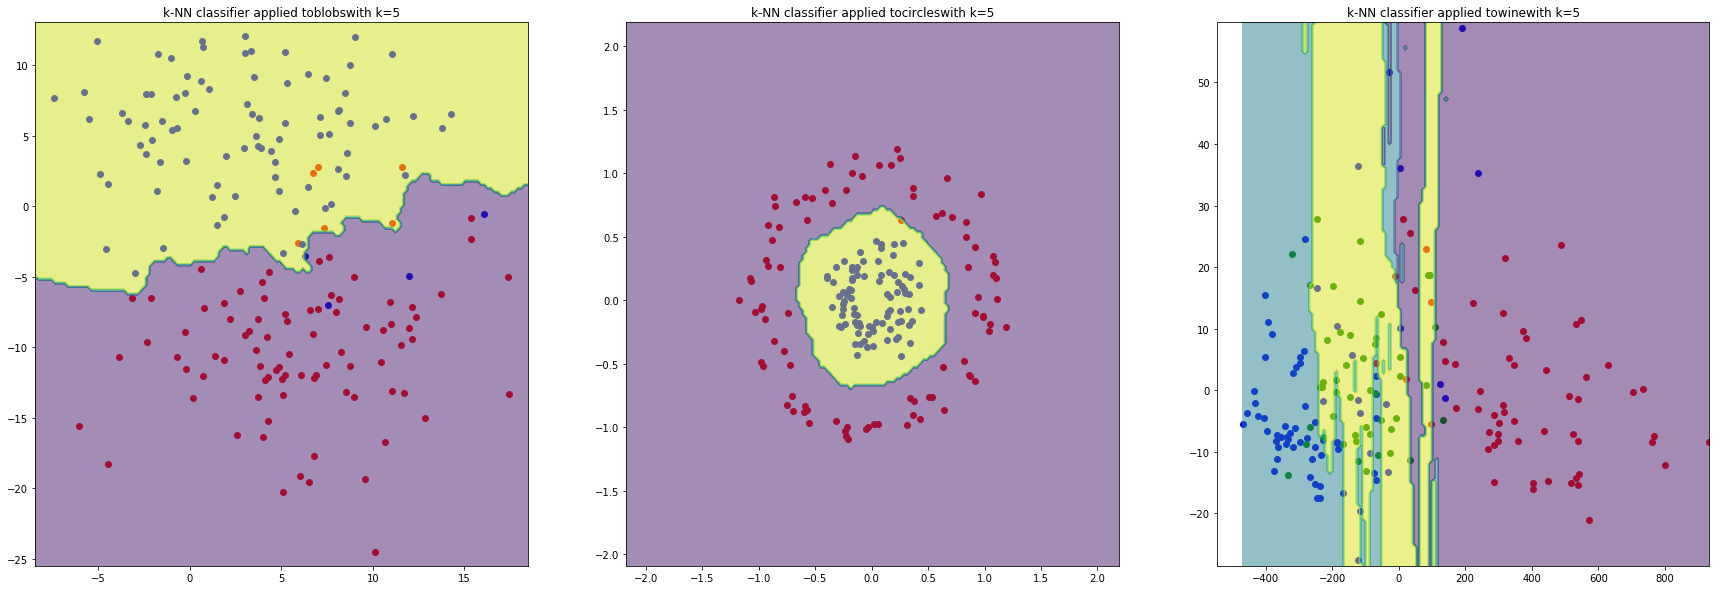

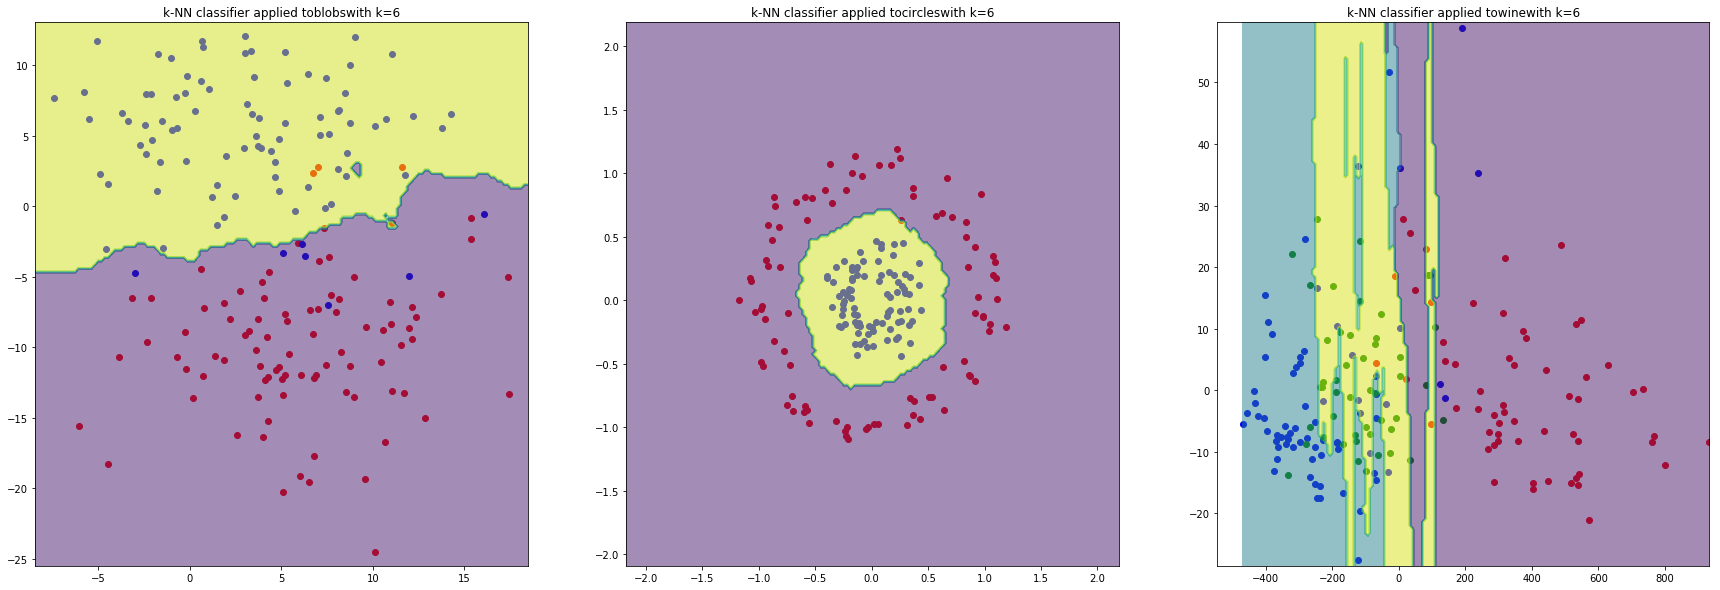

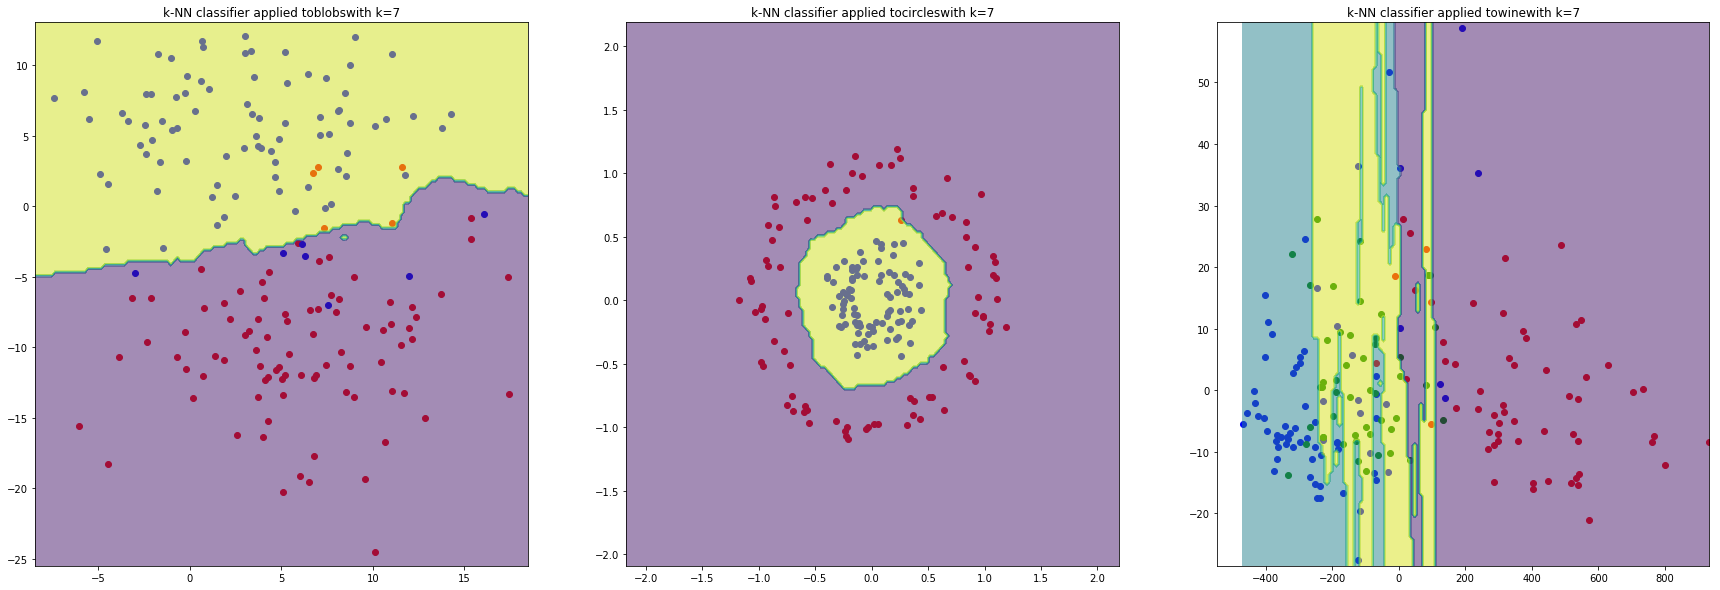

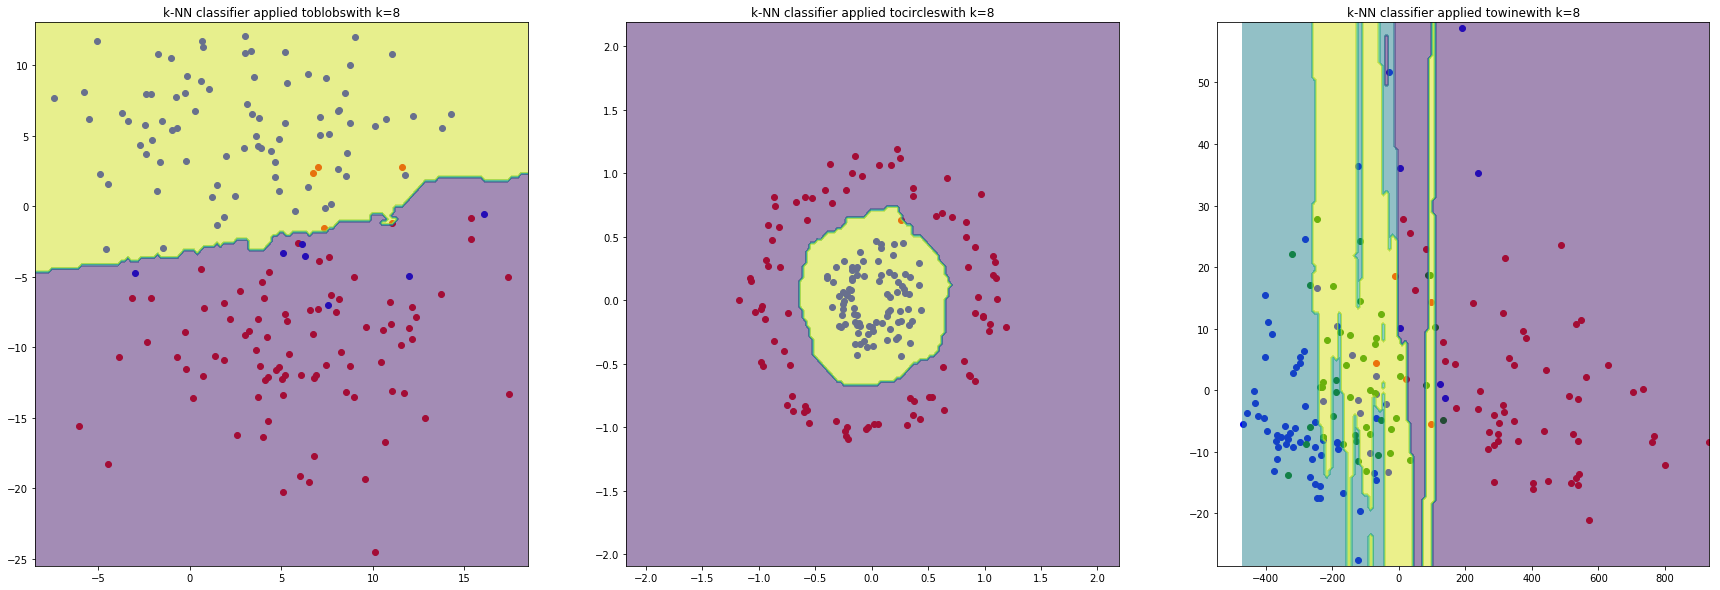

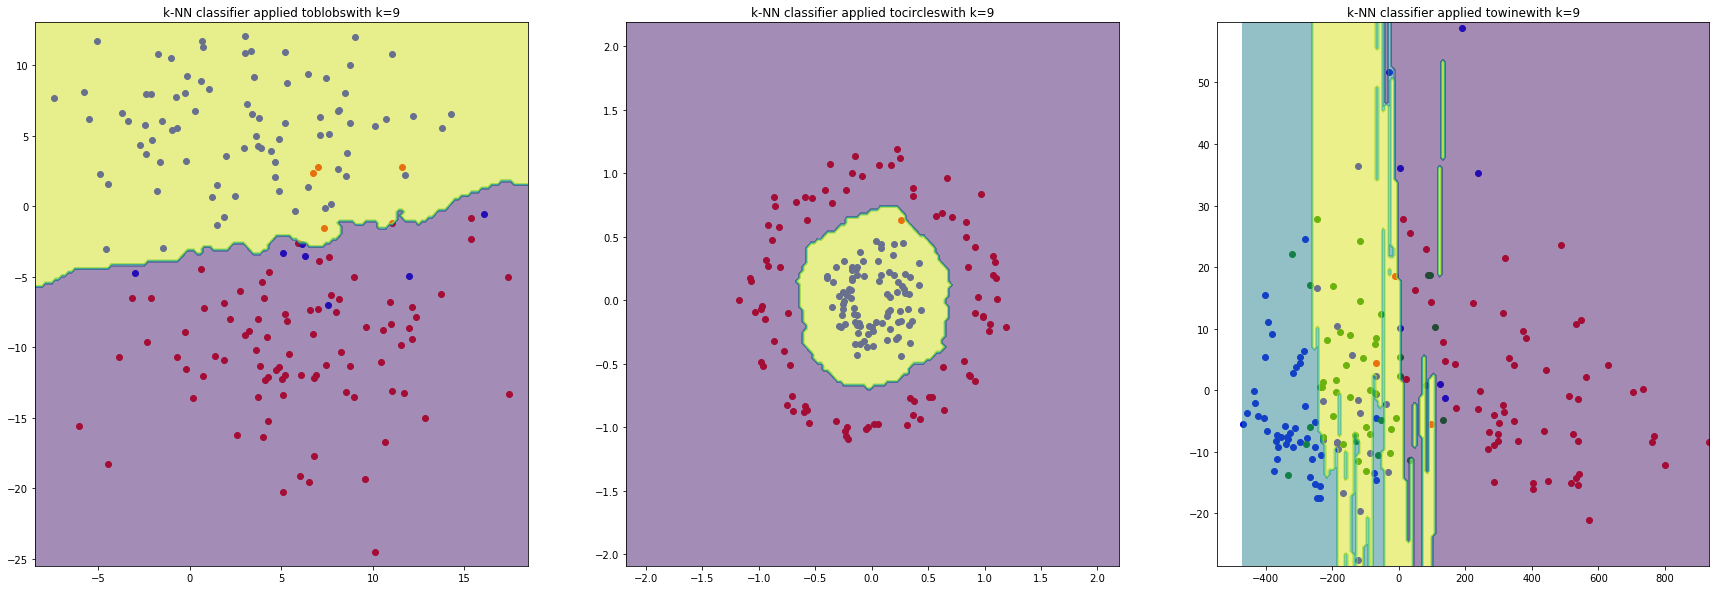

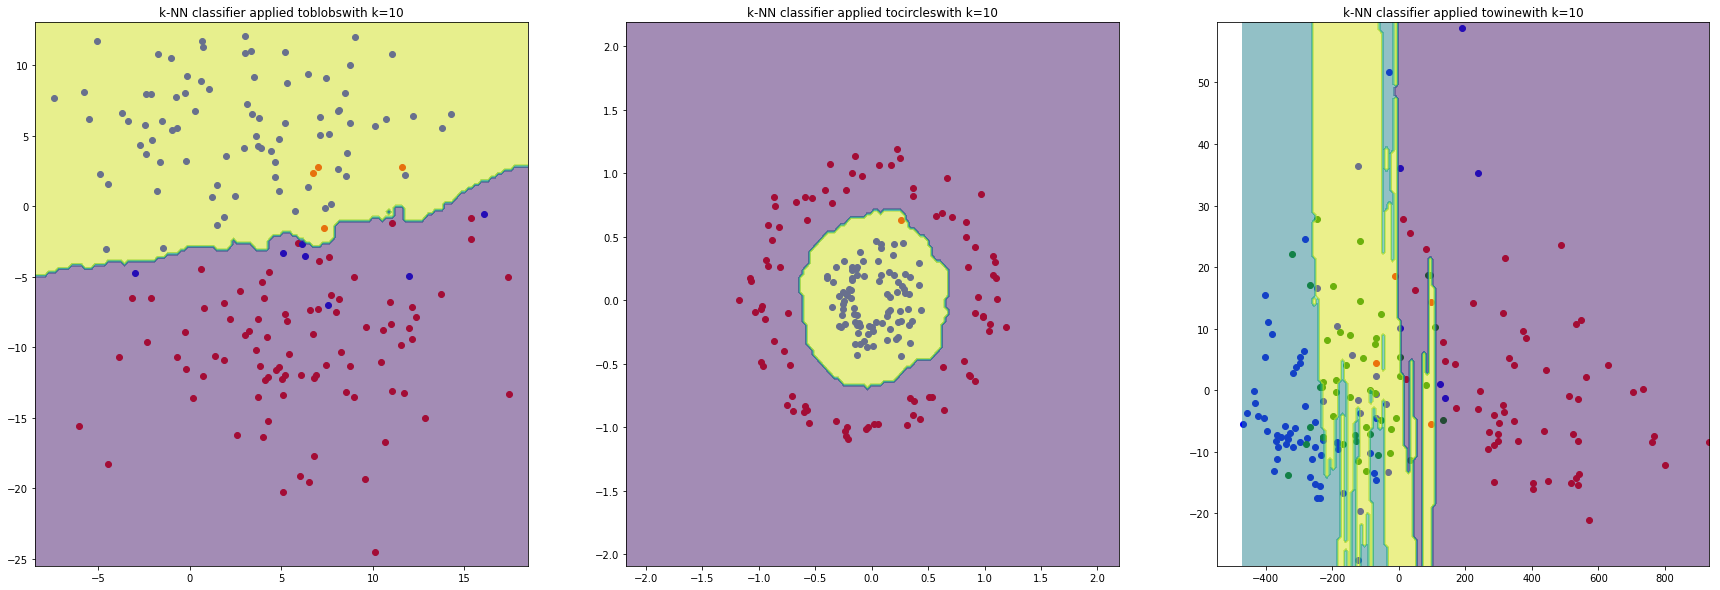

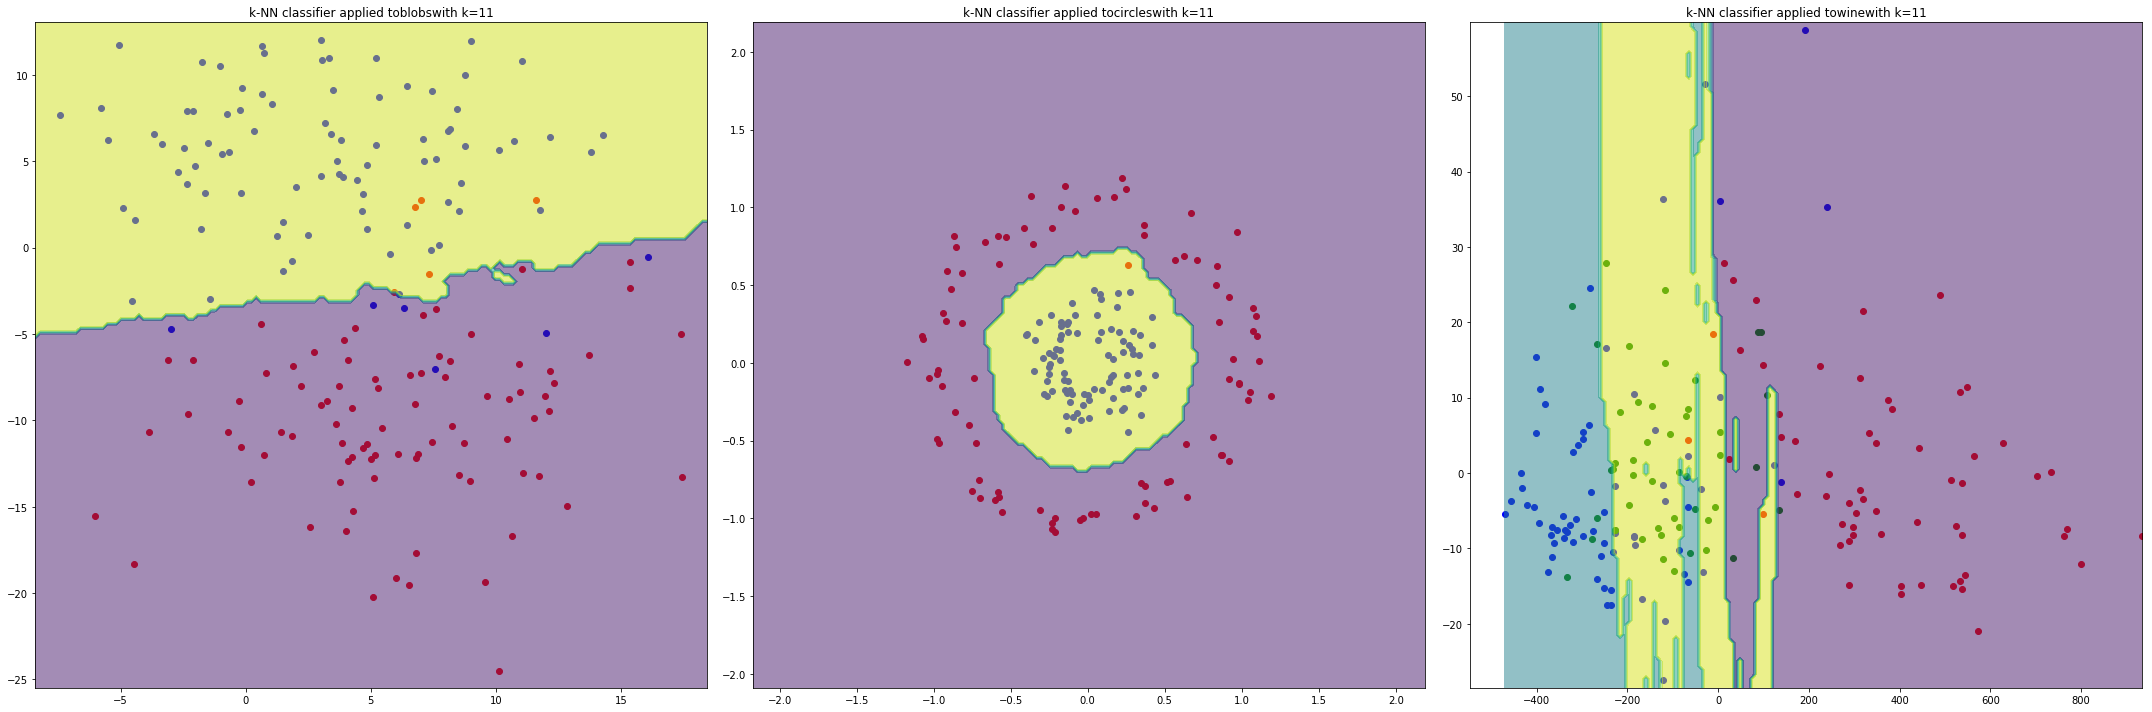

In [4]:
import sklearn.neighbors

for k in range(3,12): # Different k values are tried
    figure, axes = plt.subplots(1, 3)
    figure.set_figheight(10)
    figure.set_figwidth(30)
    for (name, X, Y), ax, colors in zip(datasets, axes, [['r', 'b'], ['r', 'b'], ['r', 'b', 'g']]):
        plot_dataset(X, Y, ax, colors=colors)
        xx, yy = mesh_from(X, 150)
        model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k).fit(X, Y)
        plot_separator(
            xx,
            yy,
            ax,
            lambda x: model.predict(x),
            cmap=plt.cm.viridis,
            alpha=0.5
        )
        ax.set_title('k-NN classifier applied to' + name + 'with k=' + str(k))

plt.tight_layout()
plt.show()

#### Commentaire

* Le k-NN réussit mieux à approcher les séparateurs (erreur de biais de plus en plus faible). 
* Le choix de $k$ joue sur l'erreur de variance.
* En effet, intuitivement, plus $k$ augmente plus les séparations sont lissées.
* Un choix très faible de $k$ correspond à du surapprentissage.

## Arbre de décision

5.
Utiliser la classe `DecisionTreeClassifier` pour compléter le code suivant. Commenter les résultats.

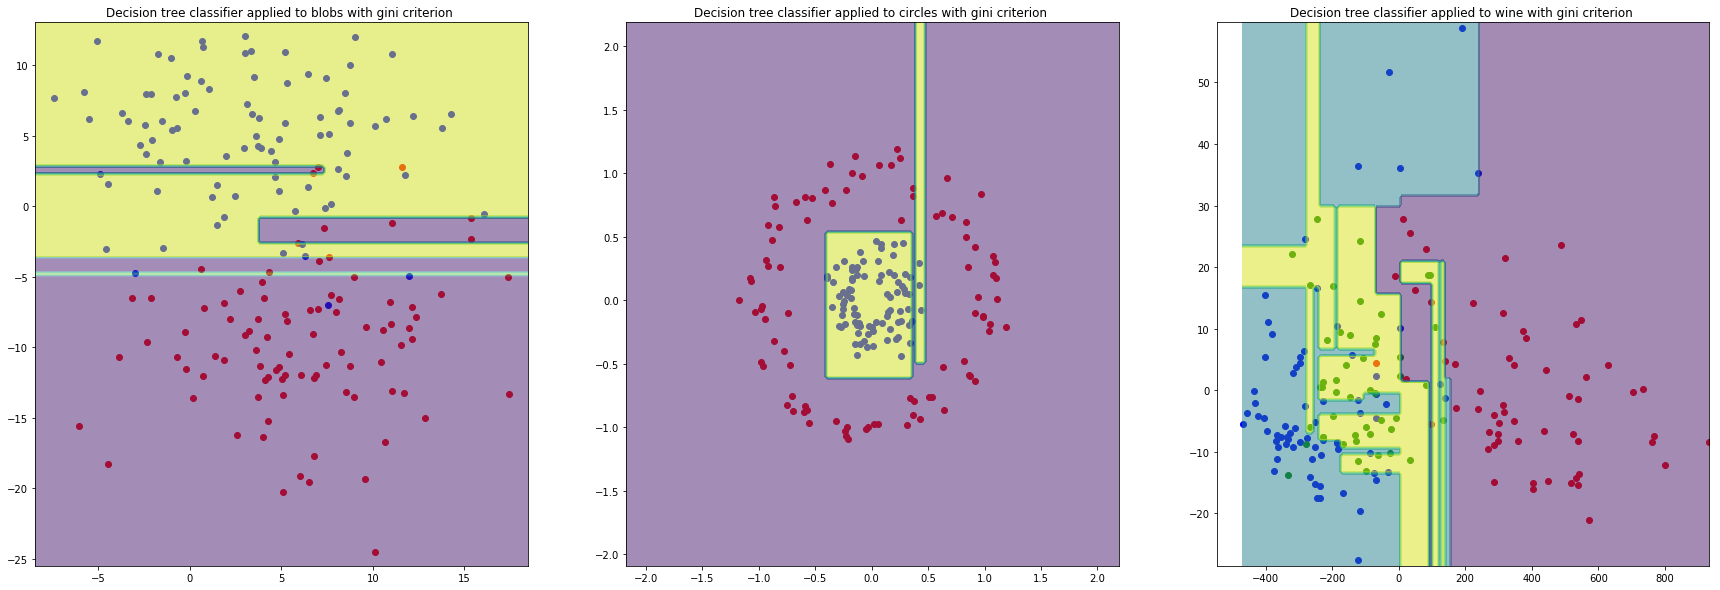

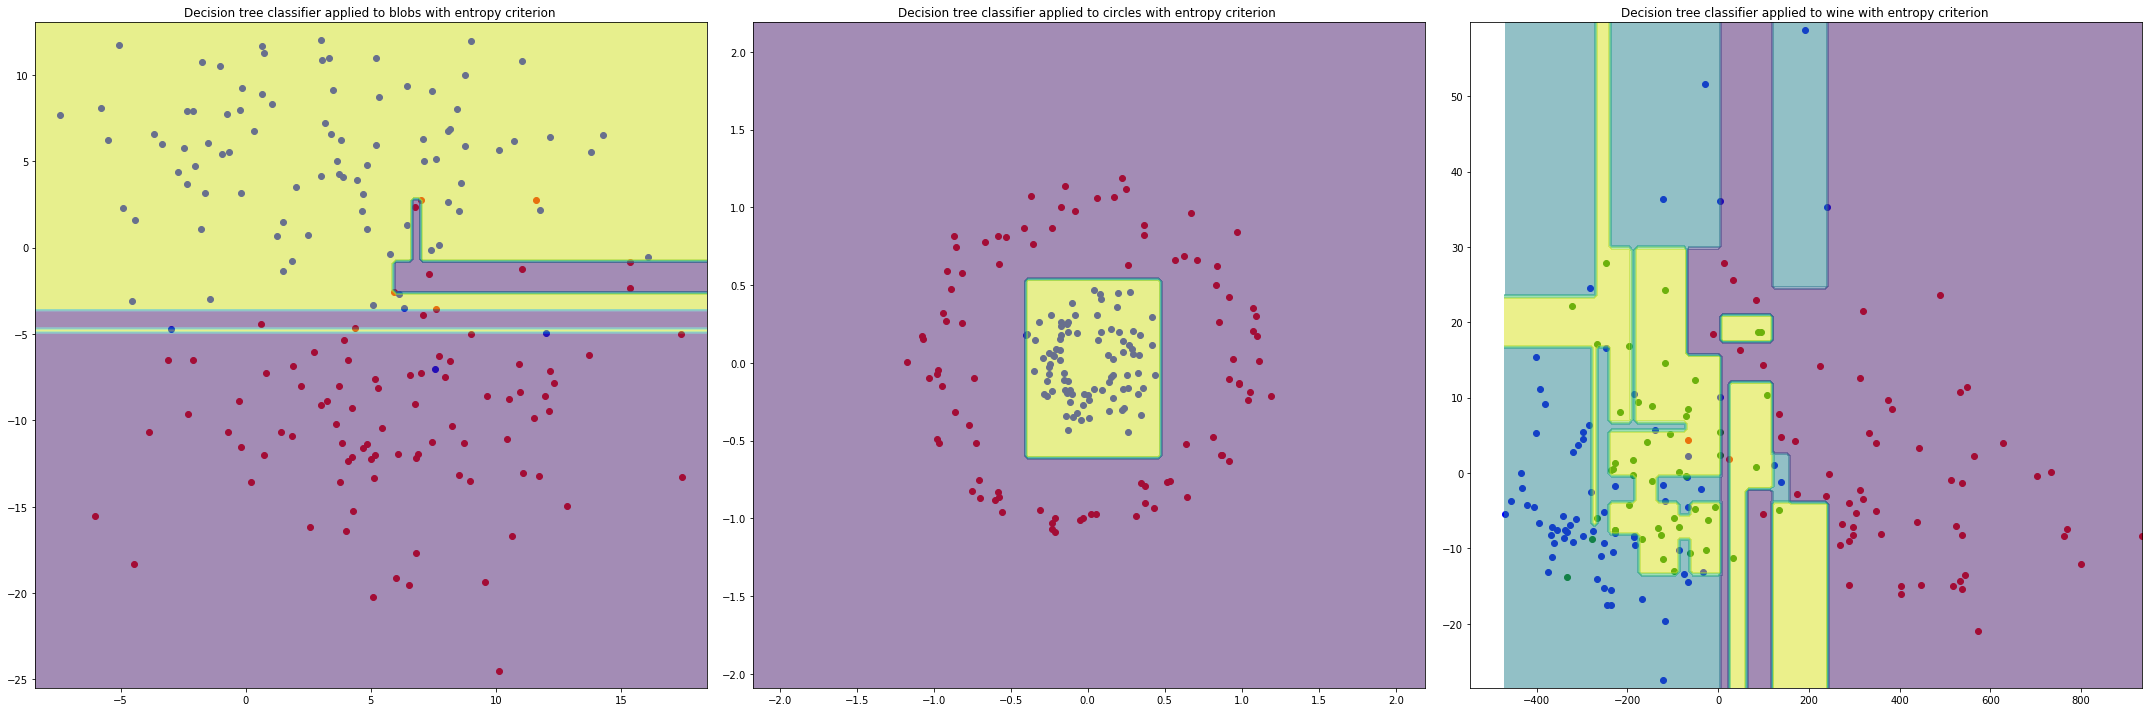

In [11]:
import sklearn.tree

for criterion in ['gini', 'entropy']:
    figure, axes = plt.subplots(1, 3)
    figure.set_figheight(10)
    figure.set_figwidth(30)
    for (name, X, Y), ax, colors in zip(datasets, axes, [['r', 'b'], ['r', 'b'], ['r', 'b', 'g']]):
        plot_dataset(X, Y, ax, colors=colors)
        xx, yy = mesh_from(X, 150)
        model = sklearn.tree.DecisionTreeClassifier(criterion=criterion).fit(X, Y)
        plot_separator(
            xx,
            yy,
            ax,
            lambda x: model.predict(x),
            cmap=plt.cm.viridis,
            alpha=0.5
        )
        ax.set_title('Decision tree classifier applied to ' + name + ' with '+ criterion + ' criterion ')

plt.tight_layout()
plt.show()

#### Commentaire

* Même si on peut remarquer des différence, le choix de mesure de chaos ne change pas, qualitativement, le résultat.
* Dans les deux cas, l'algorithme surapprend à sa façon.

6.
Imposer aux classifieur, comme critère d'arrêt, une profondeur maximale. Commenter les résultats.

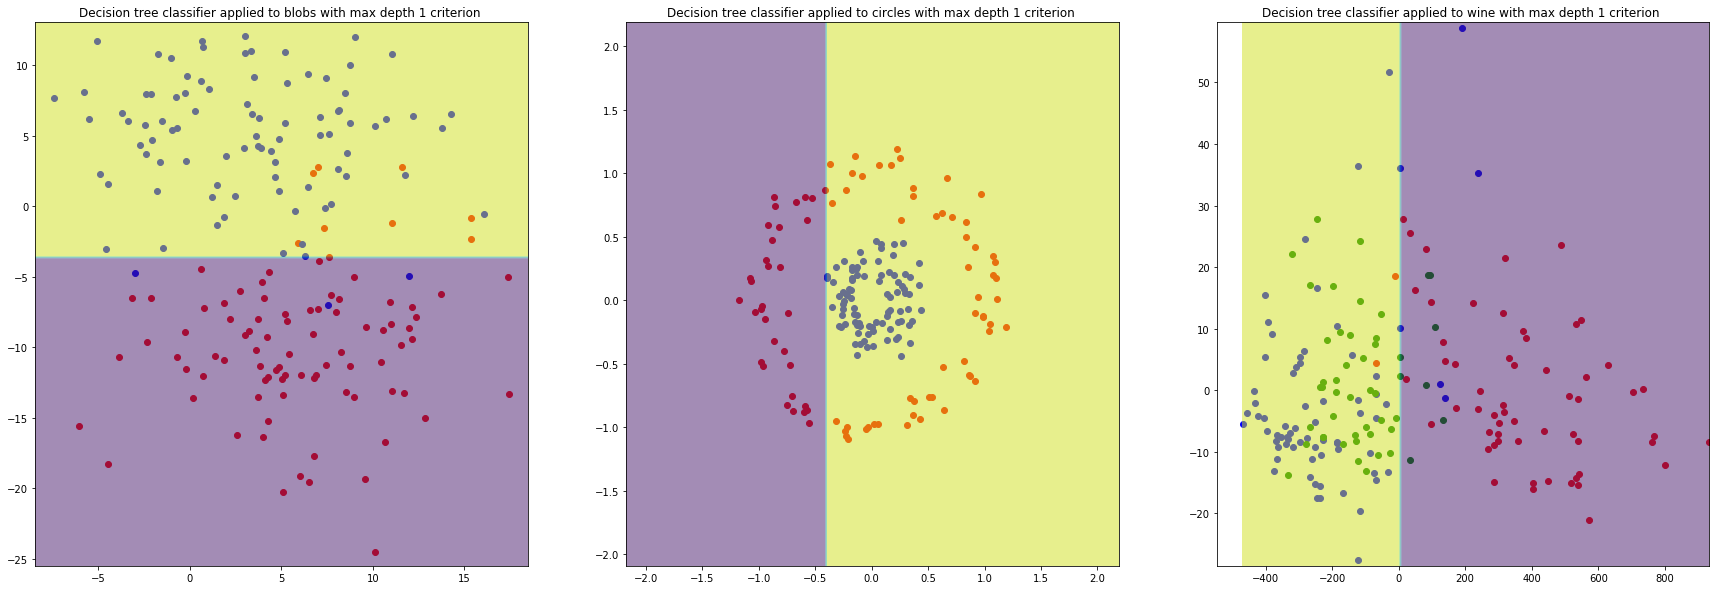

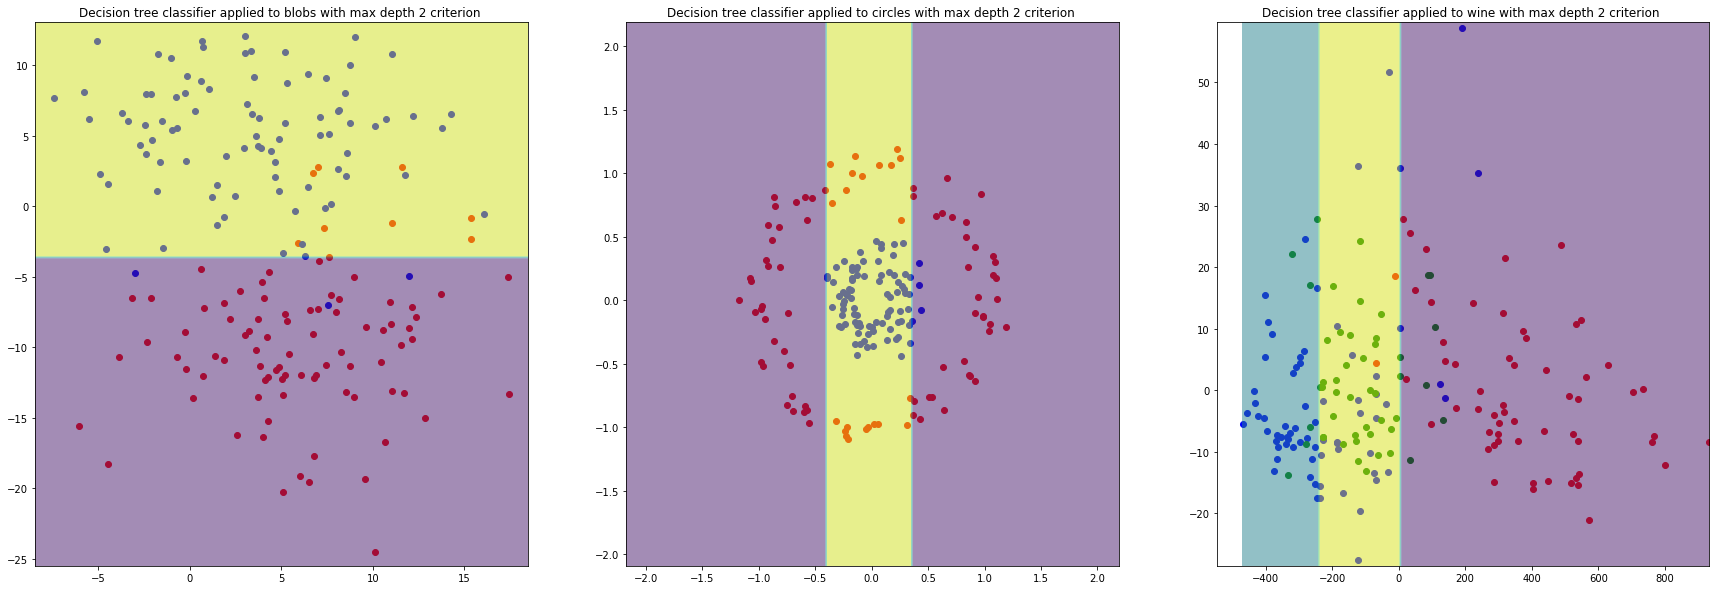

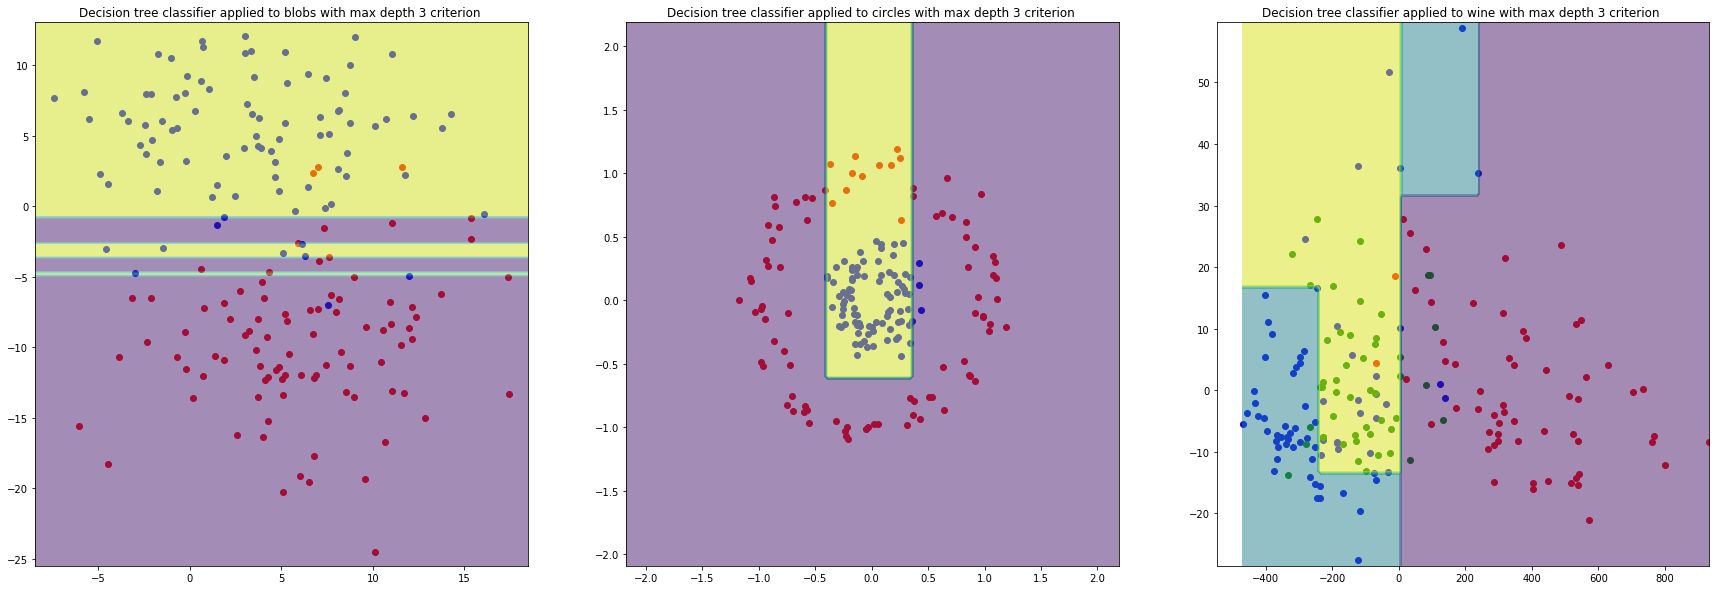

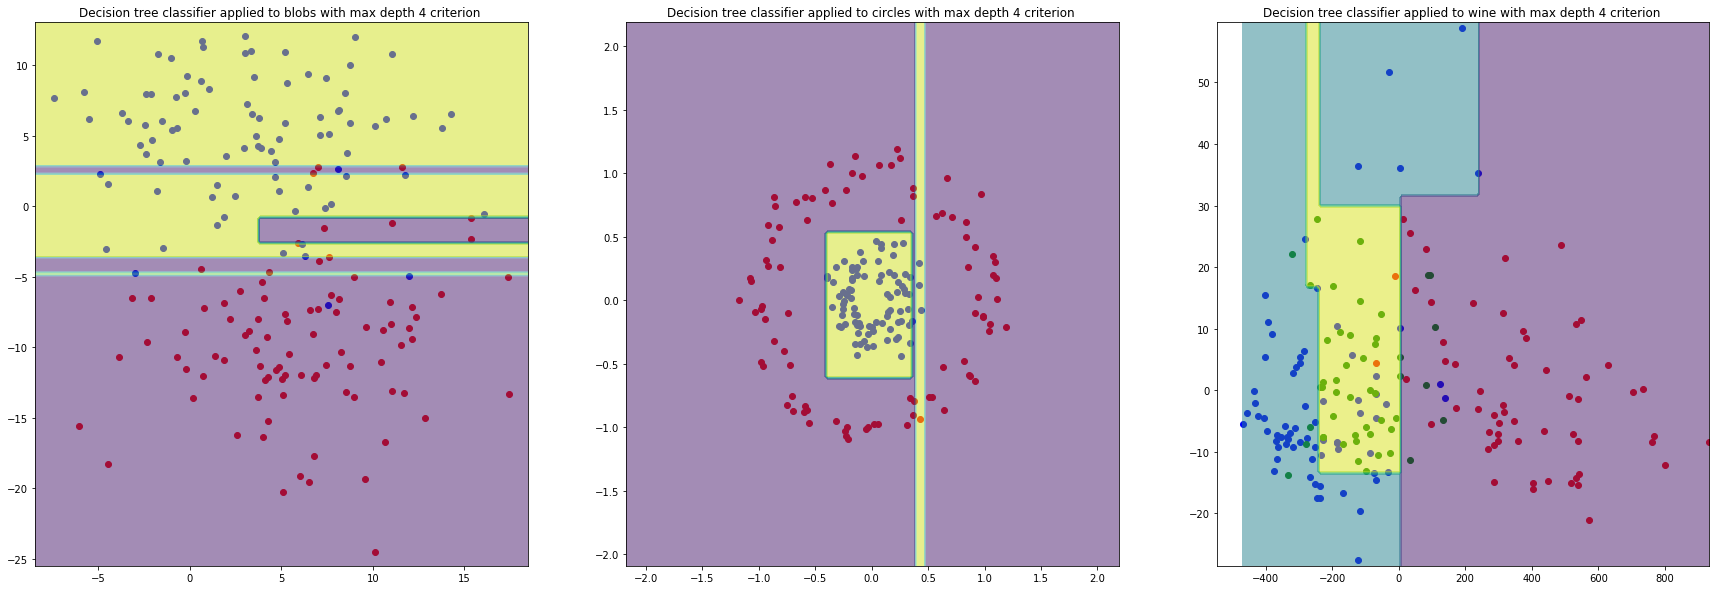

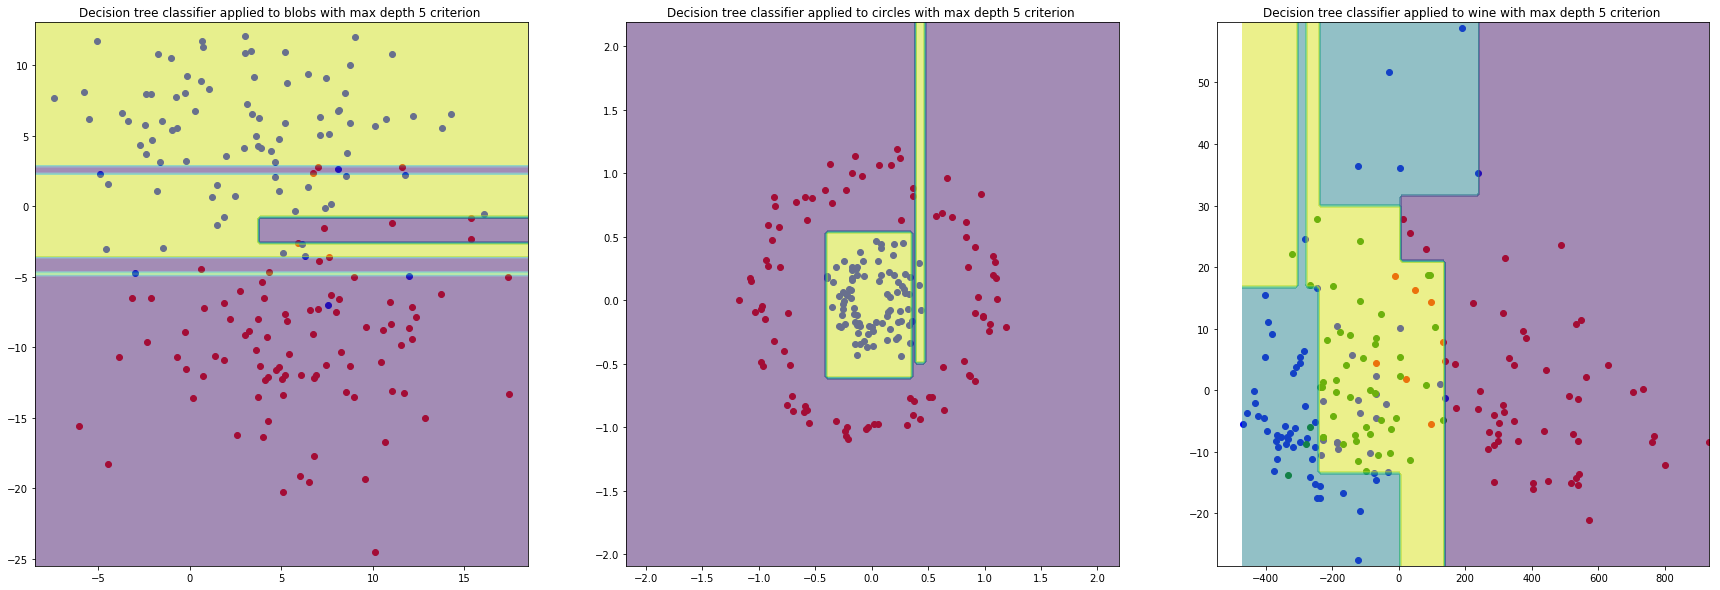

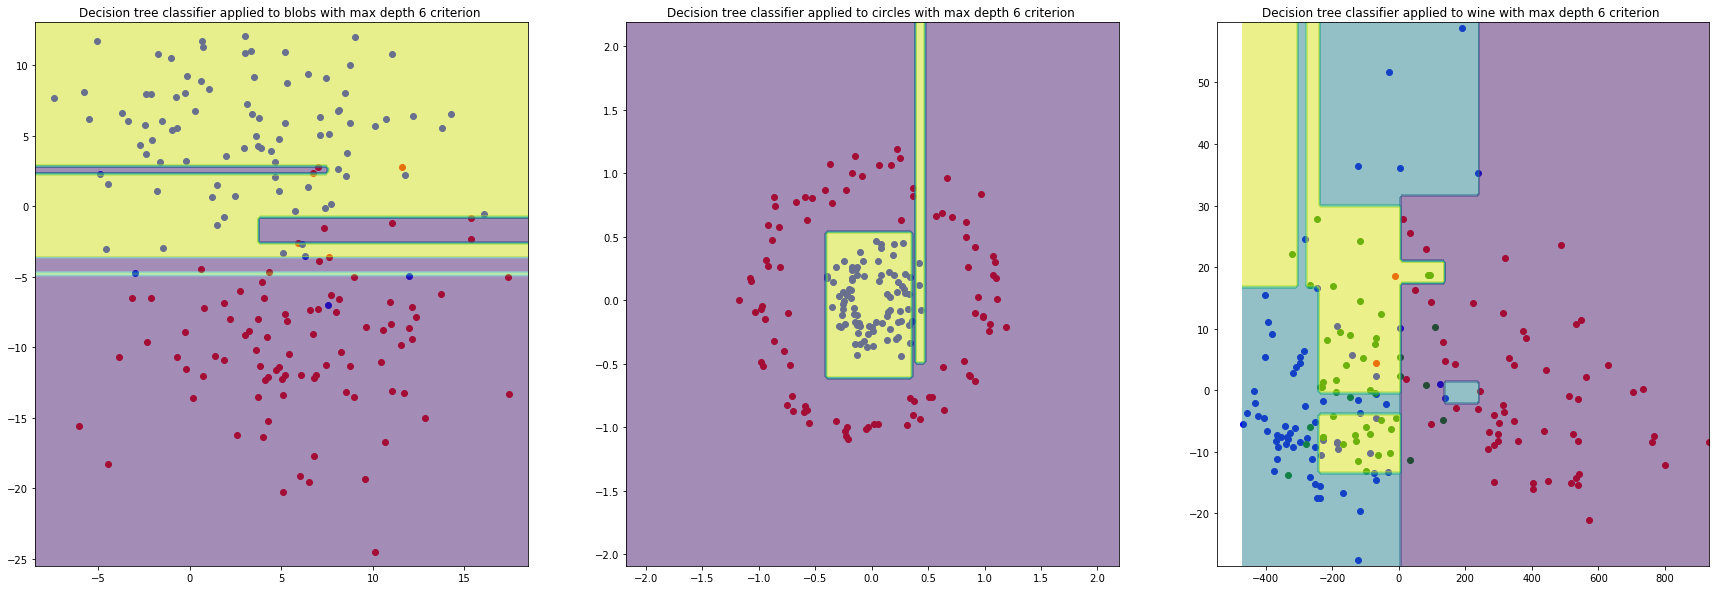

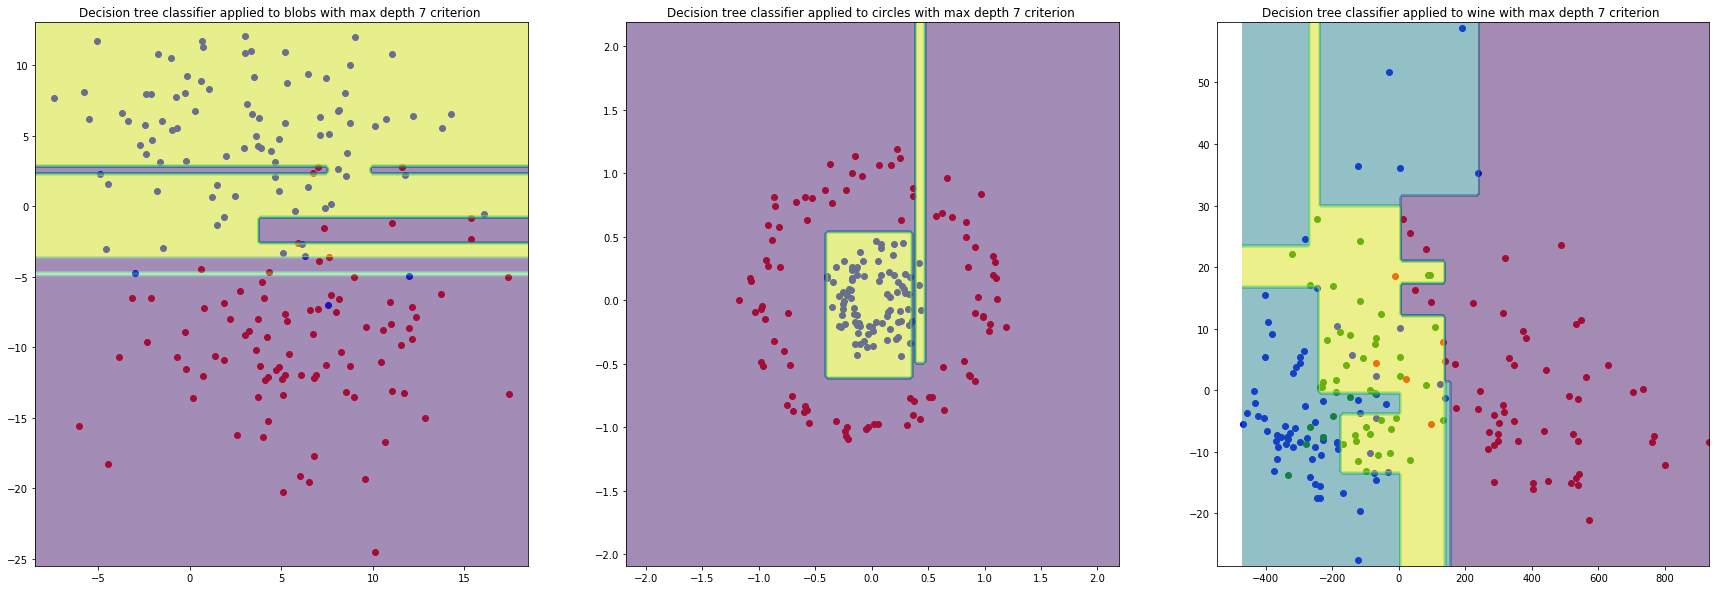

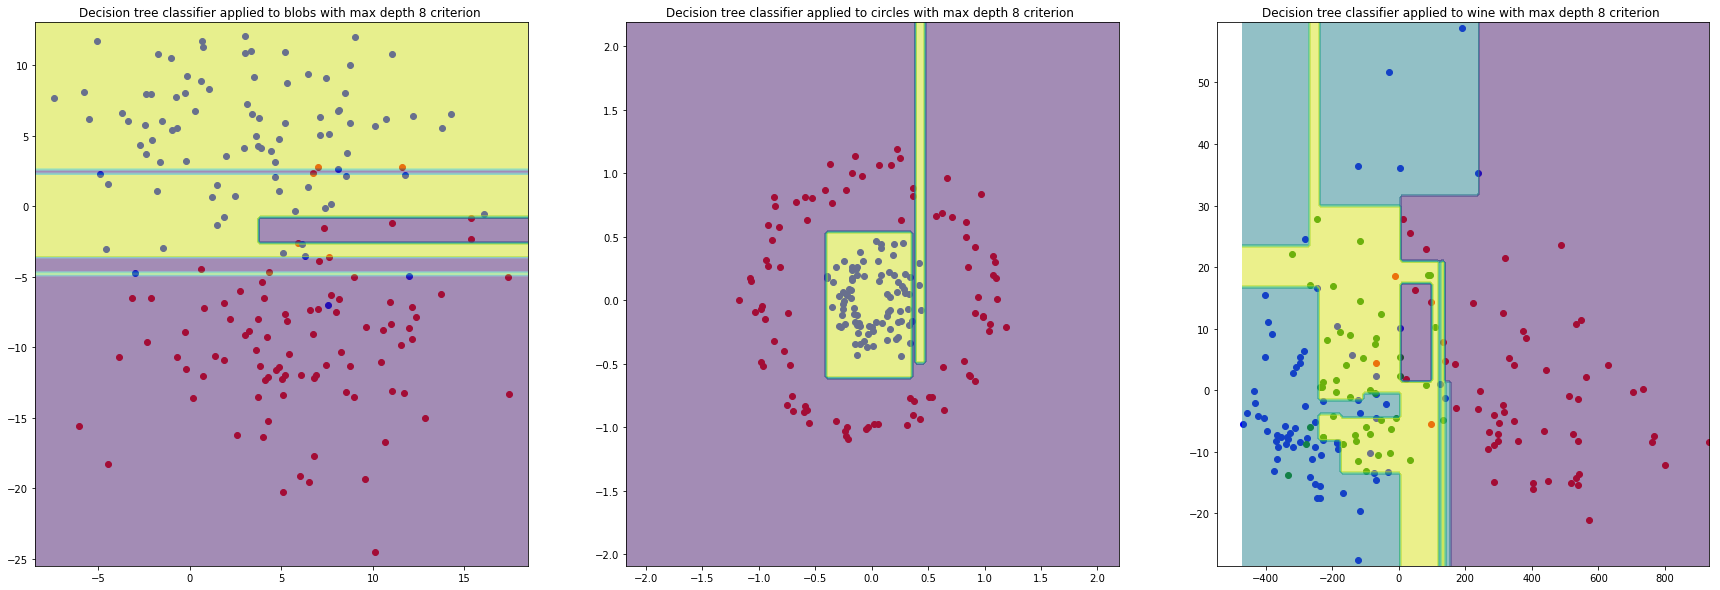

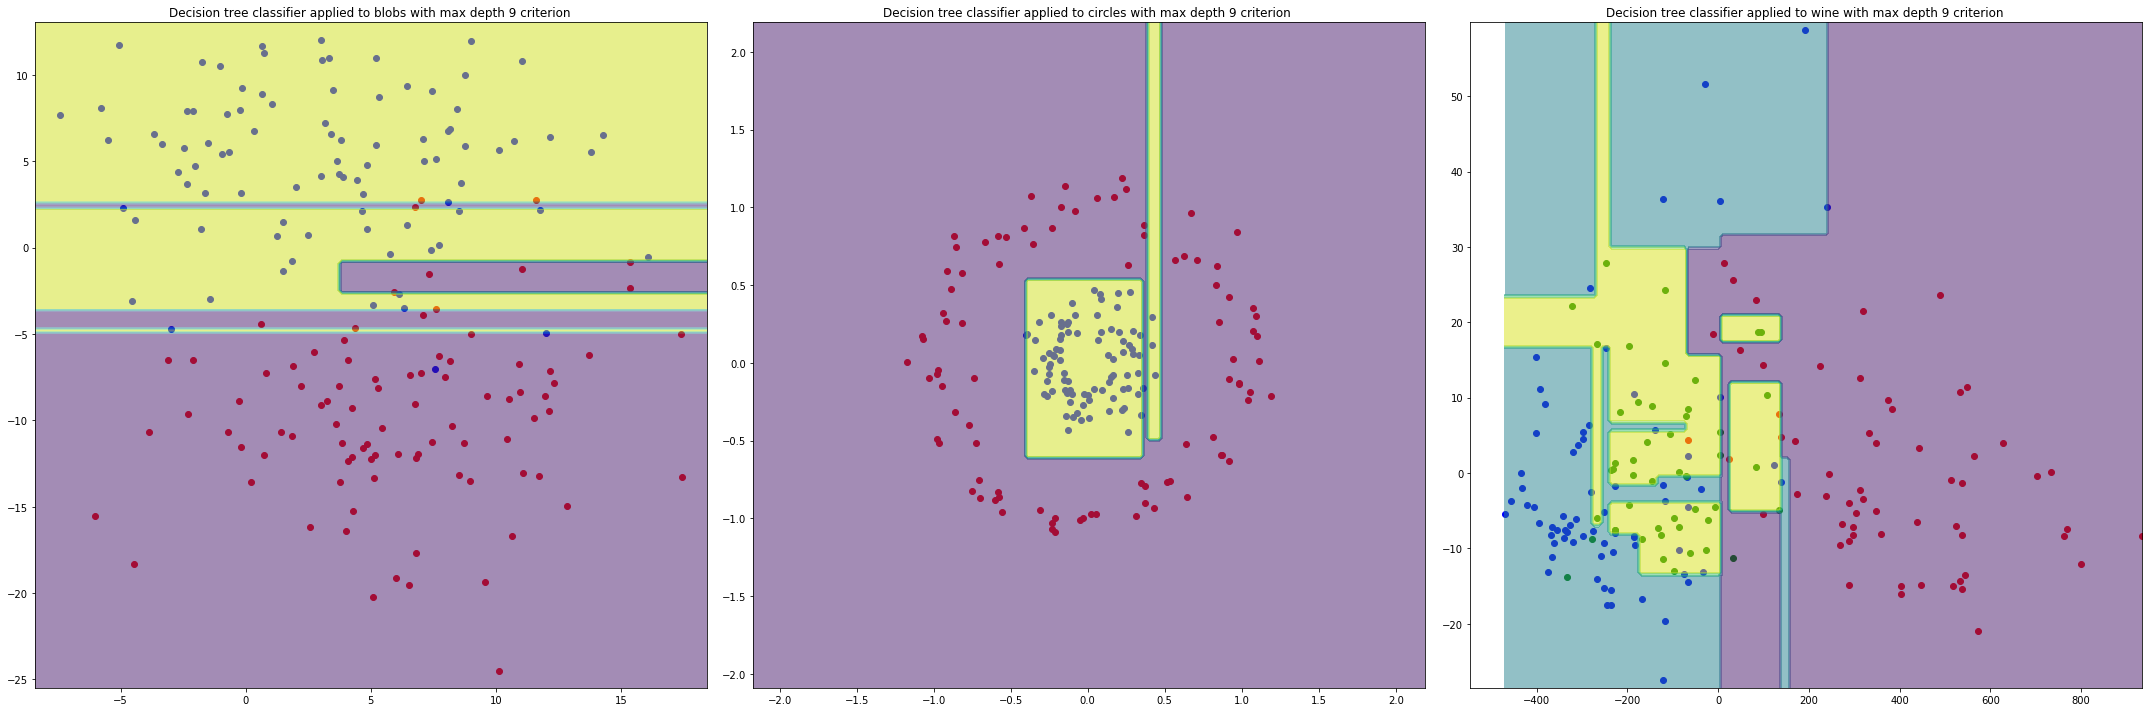

In [6]:
import sklearn.tree

for max_depth in range(1, 10):
    figure, axes = plt.subplots(1, 3)
    figure.set_figheight(10)
    figure.set_figwidth(30)
    for (name, X, Y), ax, colors in zip(datasets, axes, [['r', 'b'], ['r', 'b'], ['r', 'b', 'g']]):
        plot_dataset(X, Y, ax, colors=colors)
        xx, yy = mesh_from(X, 150)
        model = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth).fit(X, Y)
        plot_separator(
            xx,
            yy,
            ax,
            lambda x: model.predict(x),
            cmap=plt.cm.viridis,
            alpha=0.5
        )
        ax.set_title('Decision tree classifier applied to ' + name + ' with max depth '+ str(max_depth) + ' criterion ')

plt.tight_layout()
plt.show()

#### Commentaire

* Plus la profondeur maximale est grande plus l'arbre surapprend.
* Toutes les solutions restent non suffisantes.

7.
Changer le critère d'arrêt on fixant différent seuil de pureté de feuilles. Commenter.

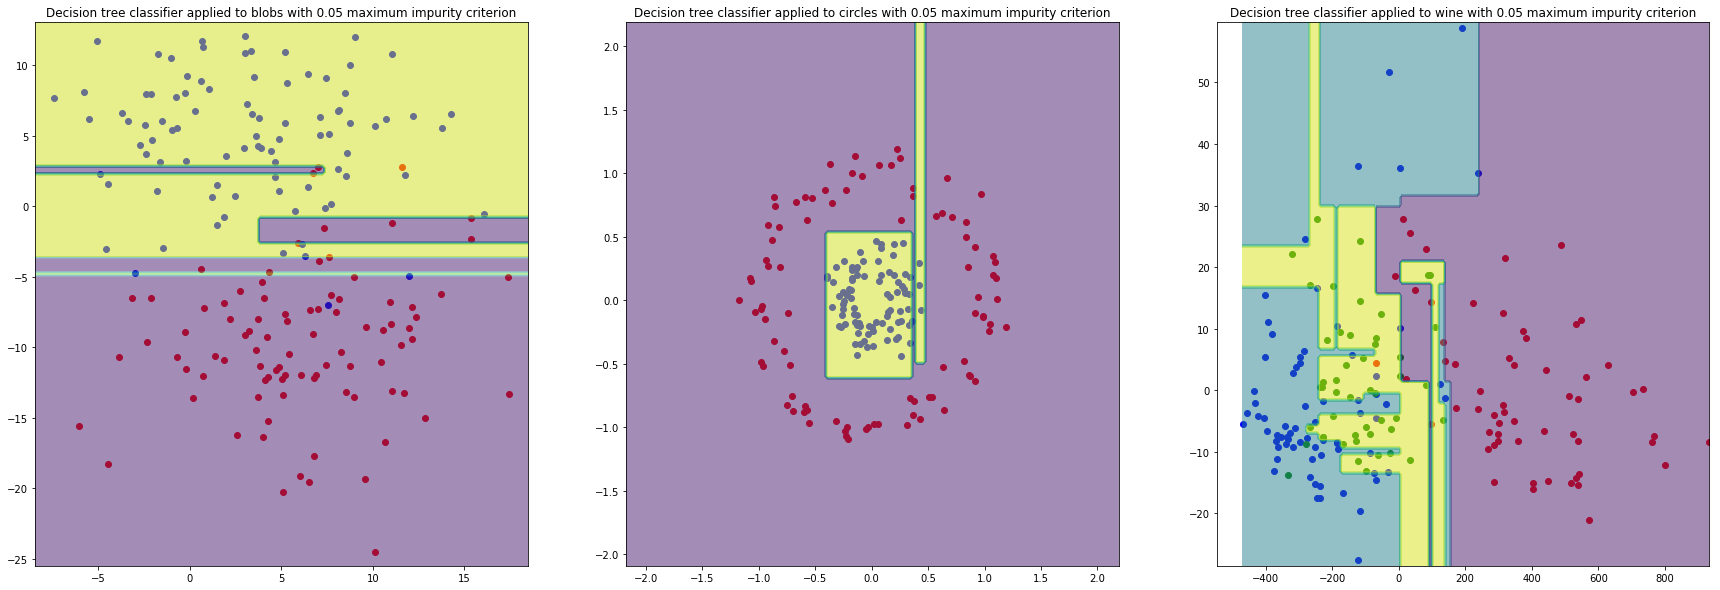

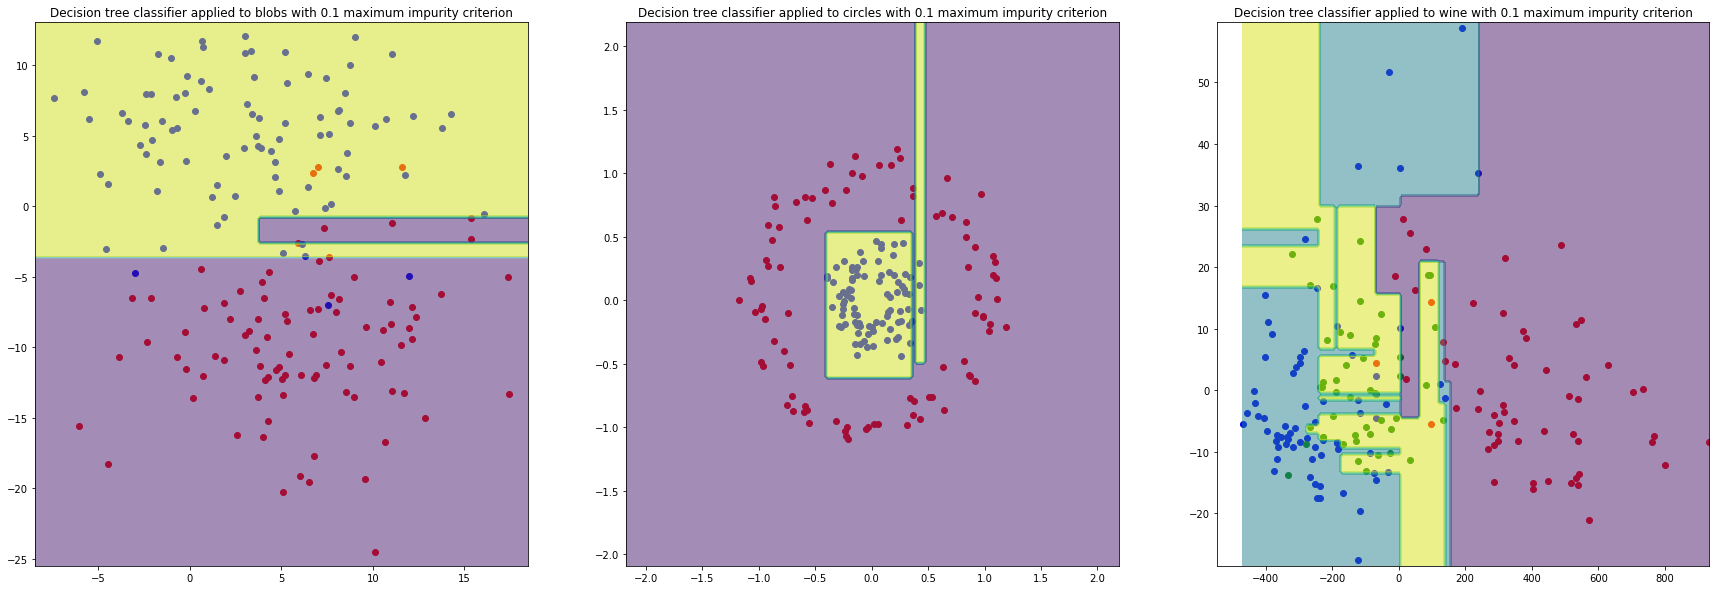

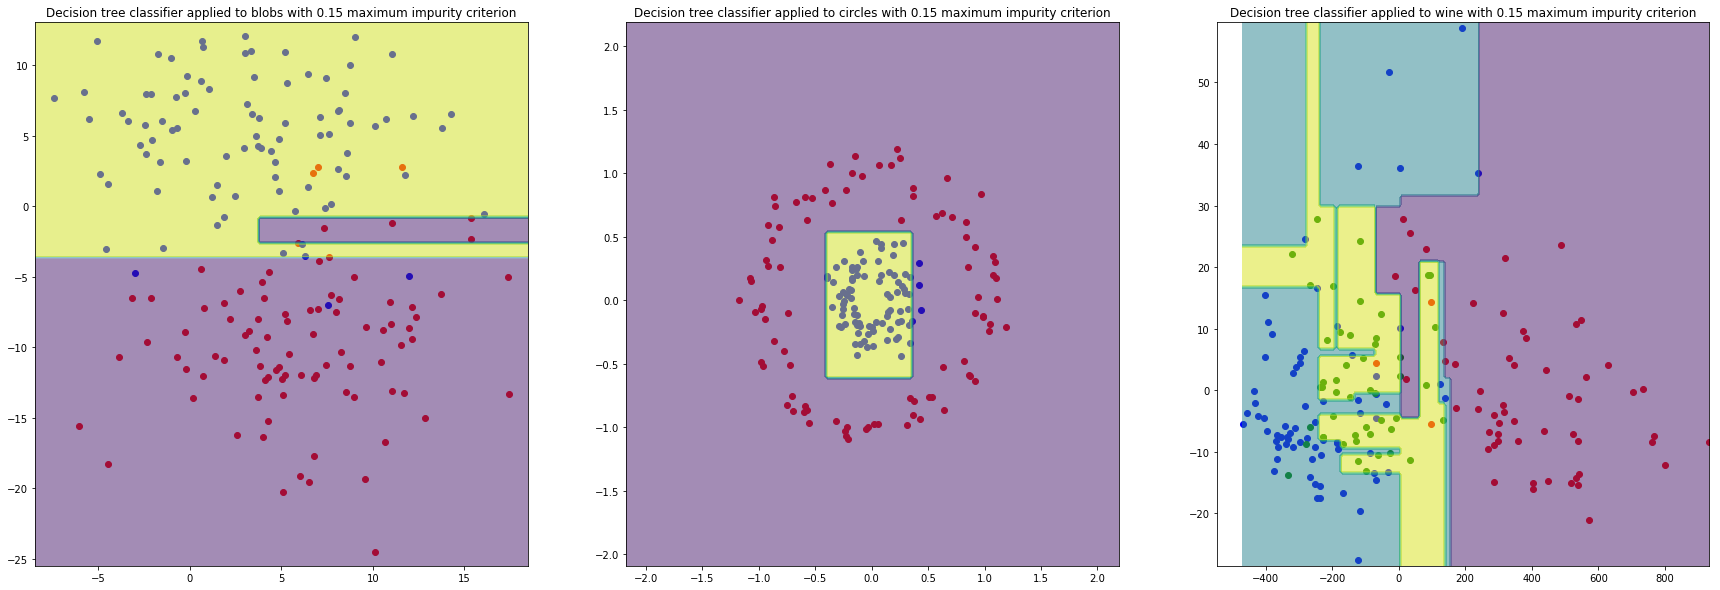

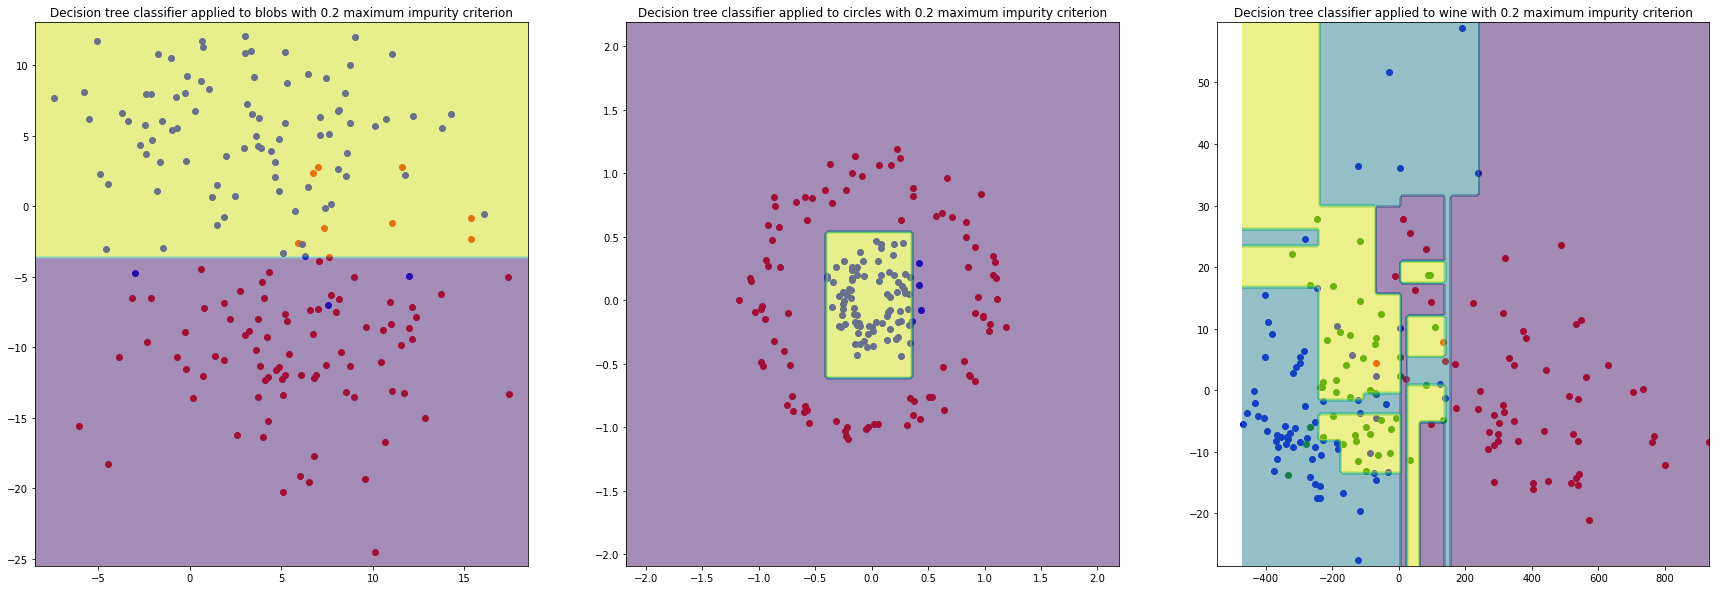

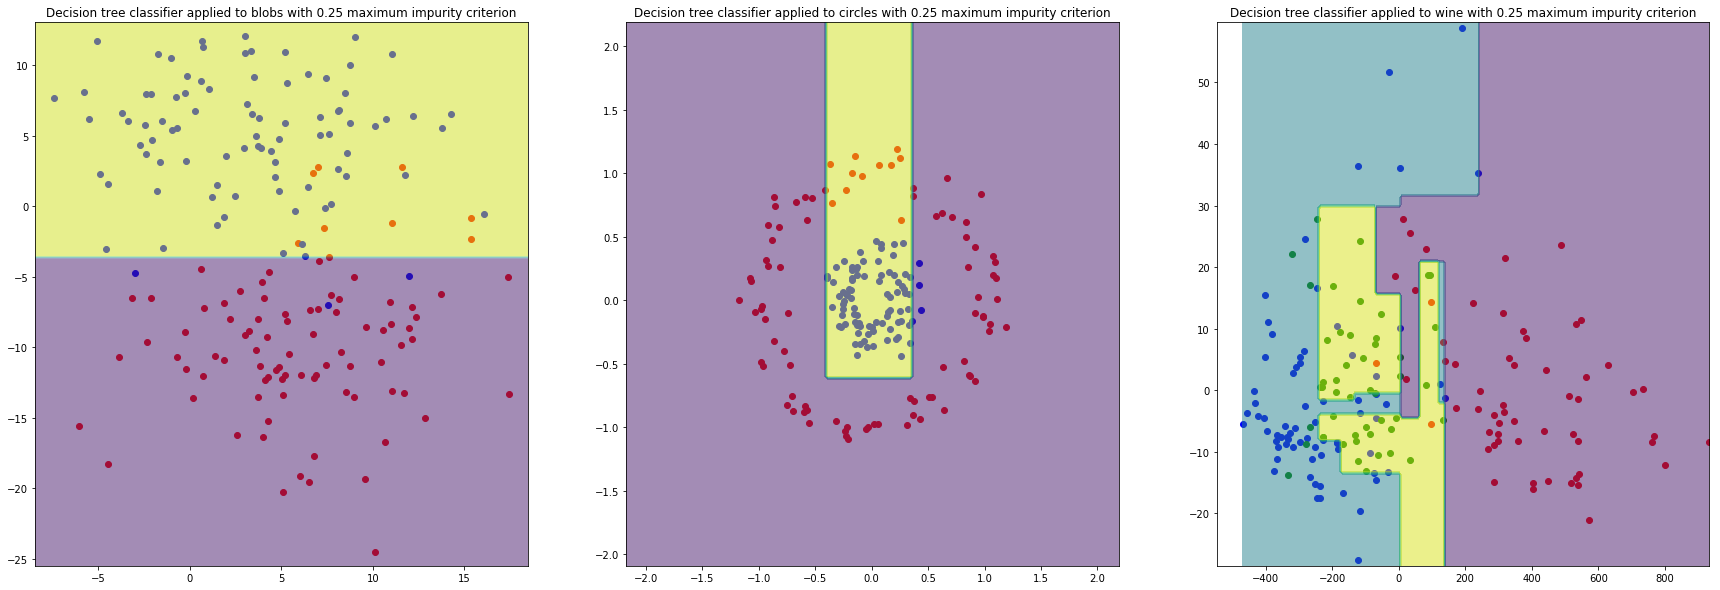

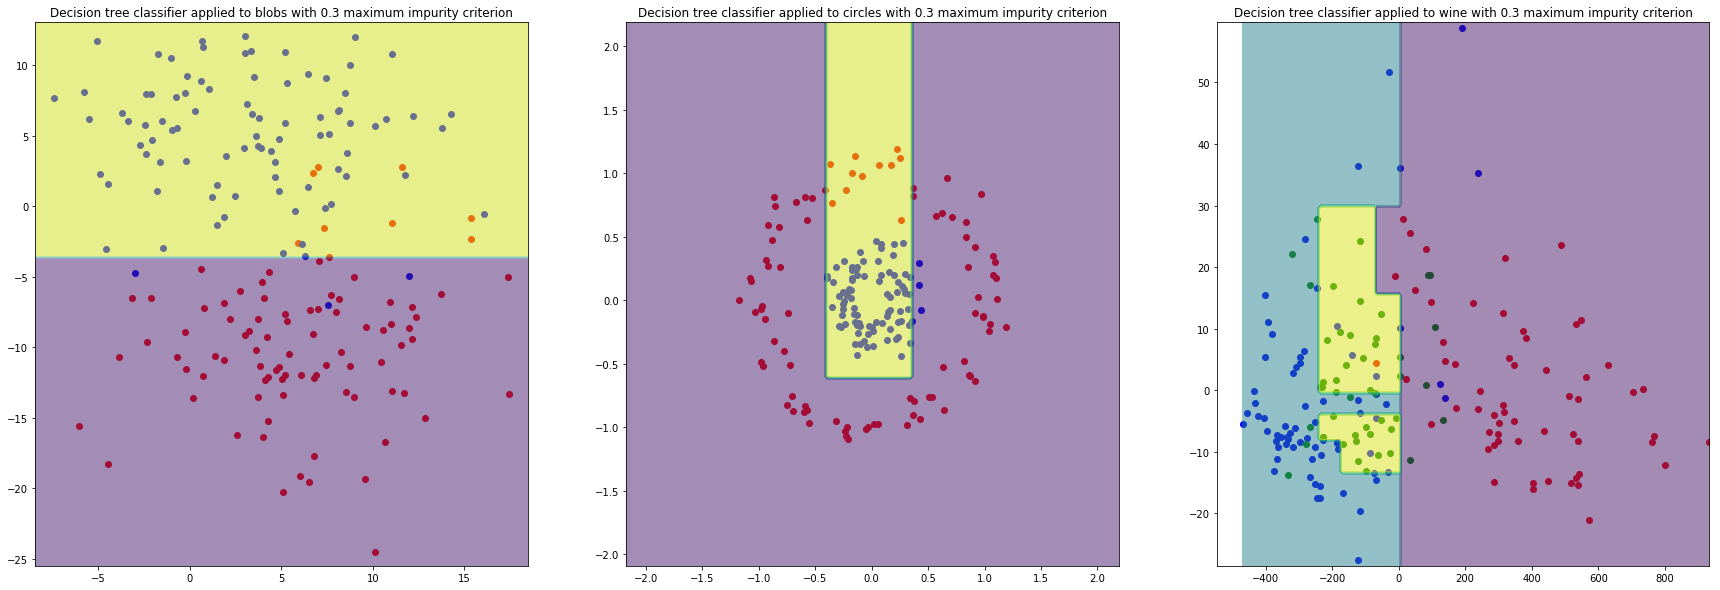

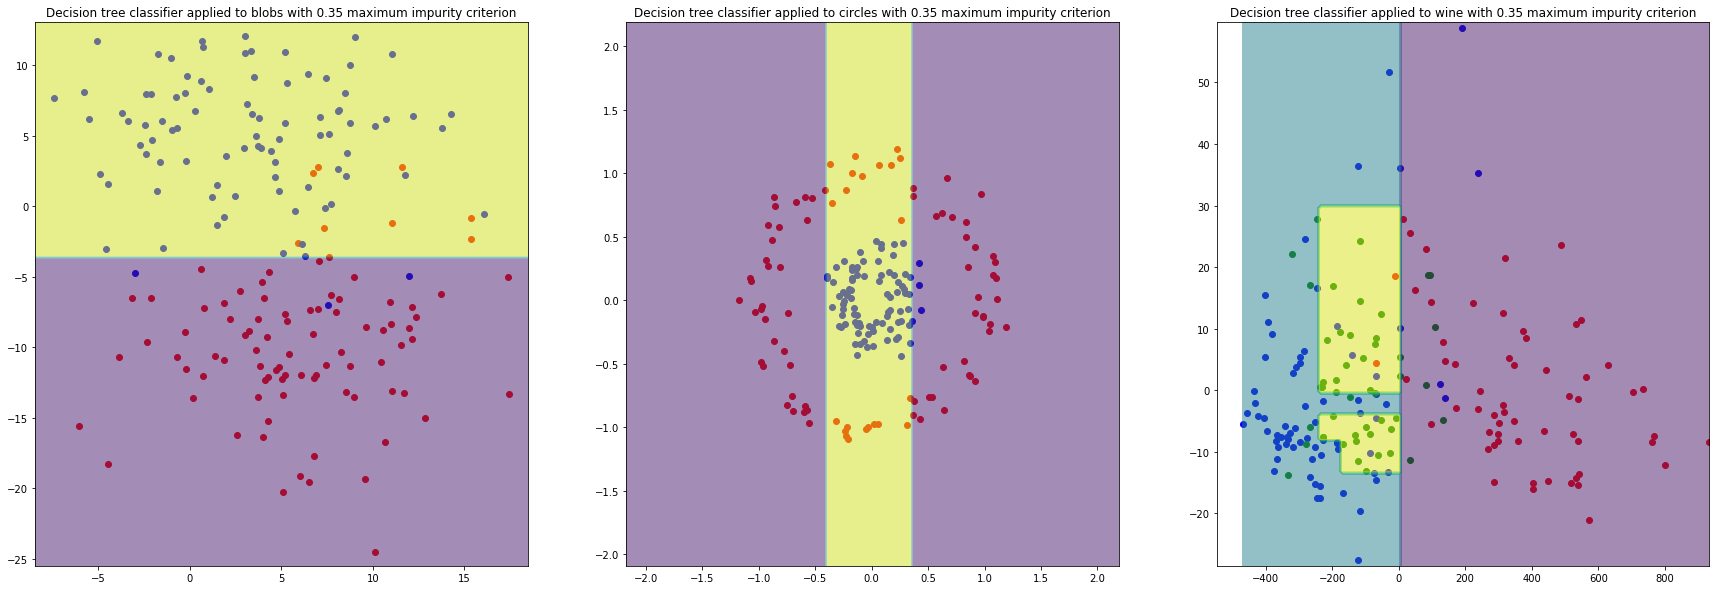

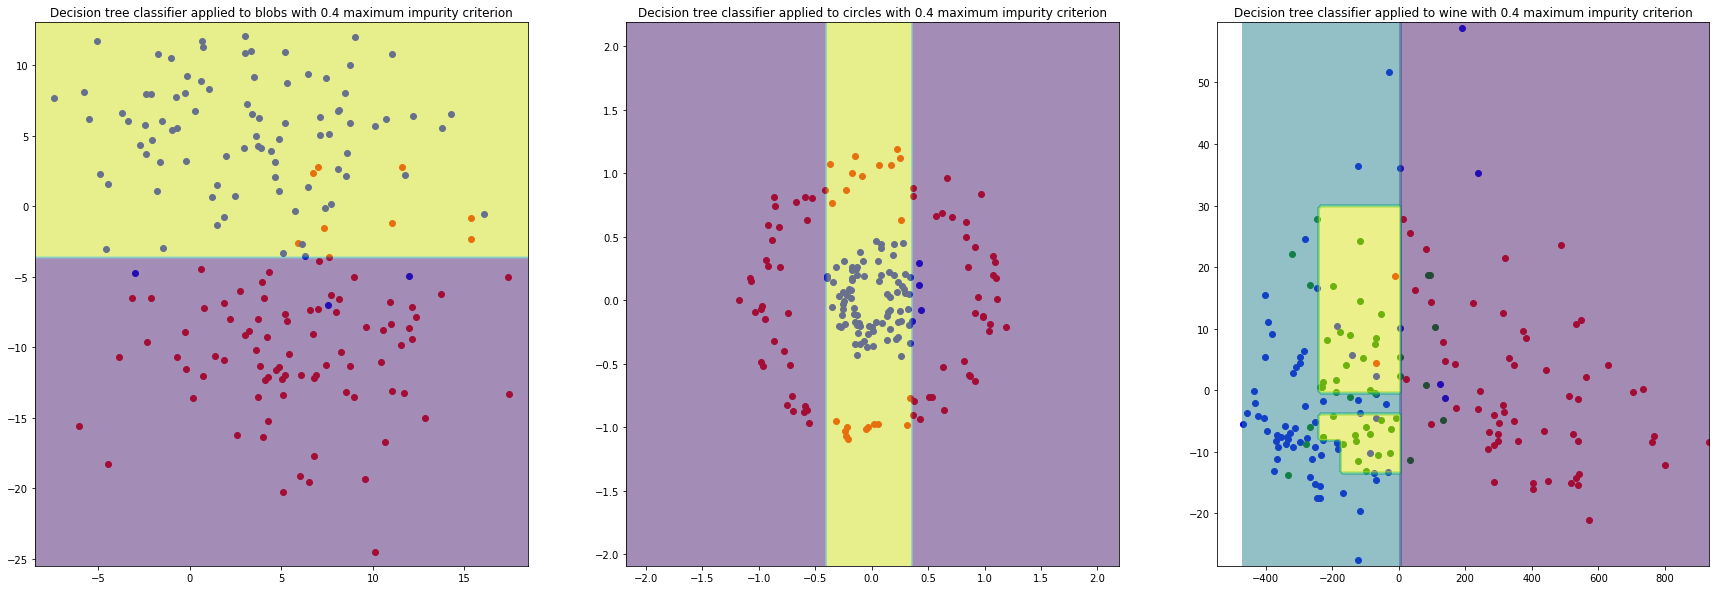

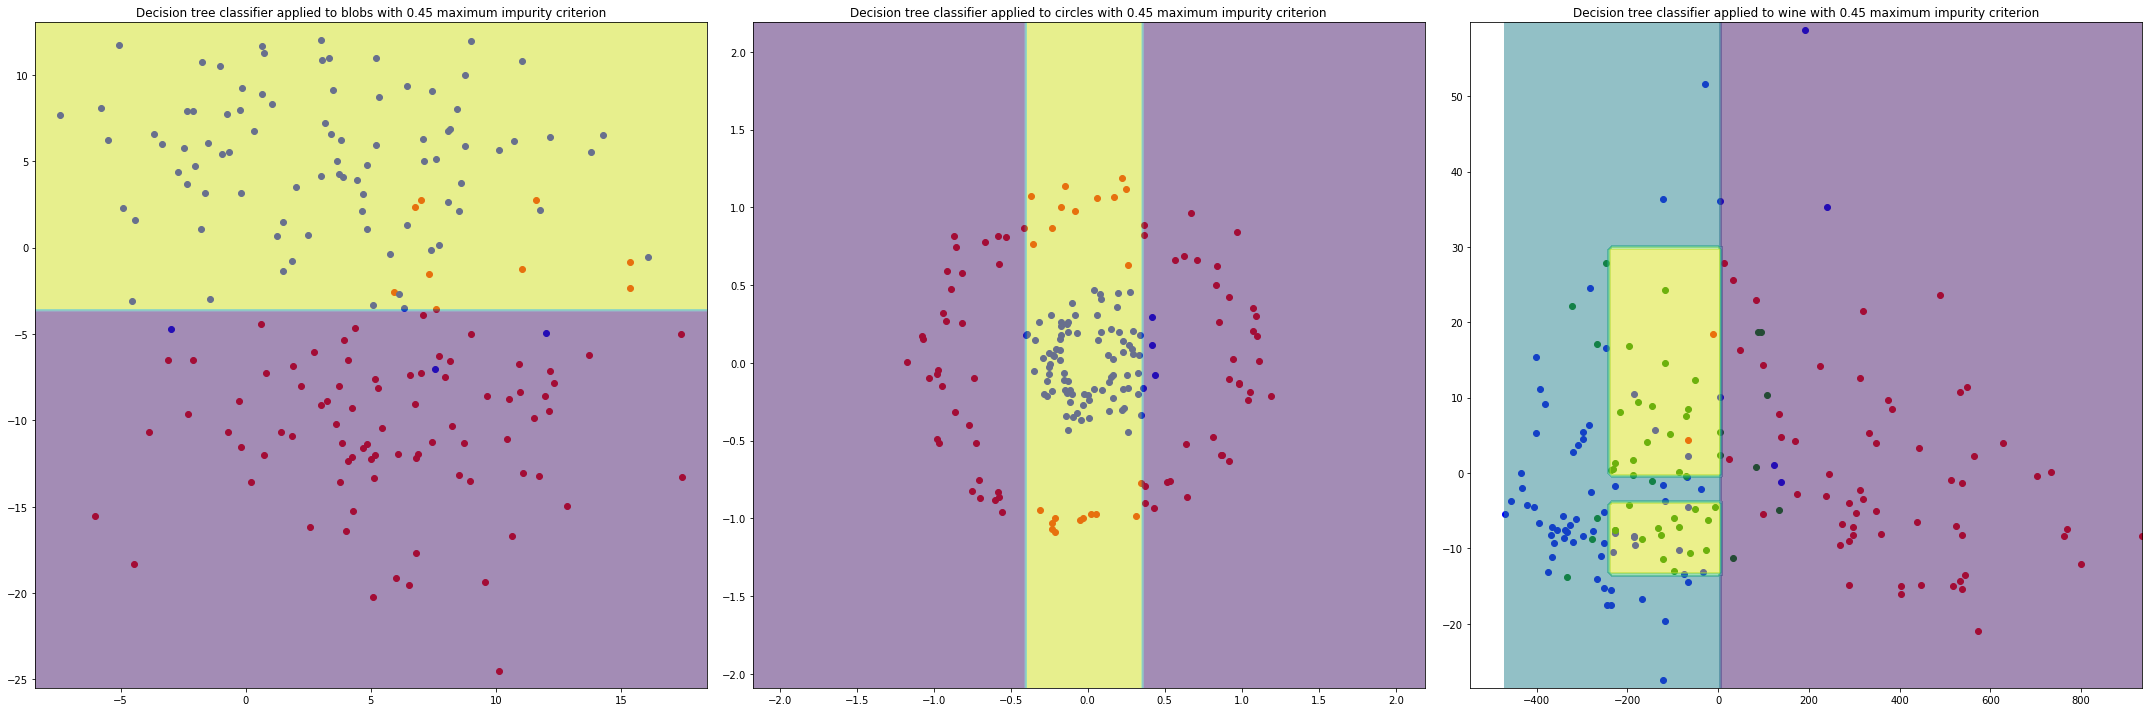

In [7]:
import sys, os
oldstderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

import sklearn.tree

for impurity in [l/20 for l in range(1, 10)]:
    figure, axes = plt.subplots(1, 3)
    figure.set_figheight(10)
    figure.set_figwidth(30)
    for (name, X, Y), ax, colors in zip(datasets, axes, [['r', 'b'], ['r', 'b'], ['r', 'b', 'g']]):
        plot_dataset(X, Y, ax, colors=colors)
        xx, yy = mesh_from(X, 150)
        model = sklearn.tree.DecisionTreeClassifier(min_impurity_split=impurity).fit(X, Y)
        plot_separator(
            xx,
            yy,
            ax,
            lambda x: model.predict(x),
            cmap=plt.cm.viridis,
            alpha=0.5
        )
        ax.set_title('Decision tree classifier applied to ' + name + ' with '+ str(impurity) + ' maximum impurity criterion')

plt.tight_layout()
plt.show()

sys.stderr = oldstderr

#### Commentaire

* Le choix de seuil d'impureté ($1 - $ la pureté) comme critère d'arrêt influence plus les résultats que la profondeur maximal.
* Plus l'impureté augmente plus l'erreur de variance est accepté, et donc moins de surapprentissage se produit
* Les meilleurs choix par base de données:
  1. 0.2
  2. 0.15
  3. 0.3

## Forêt aléatoire

8.
Compléter les fonctions `select_attributes`, `random_forest_train` et `random_forest_test`, puis lancer le code suivant. Commenter les résultats.

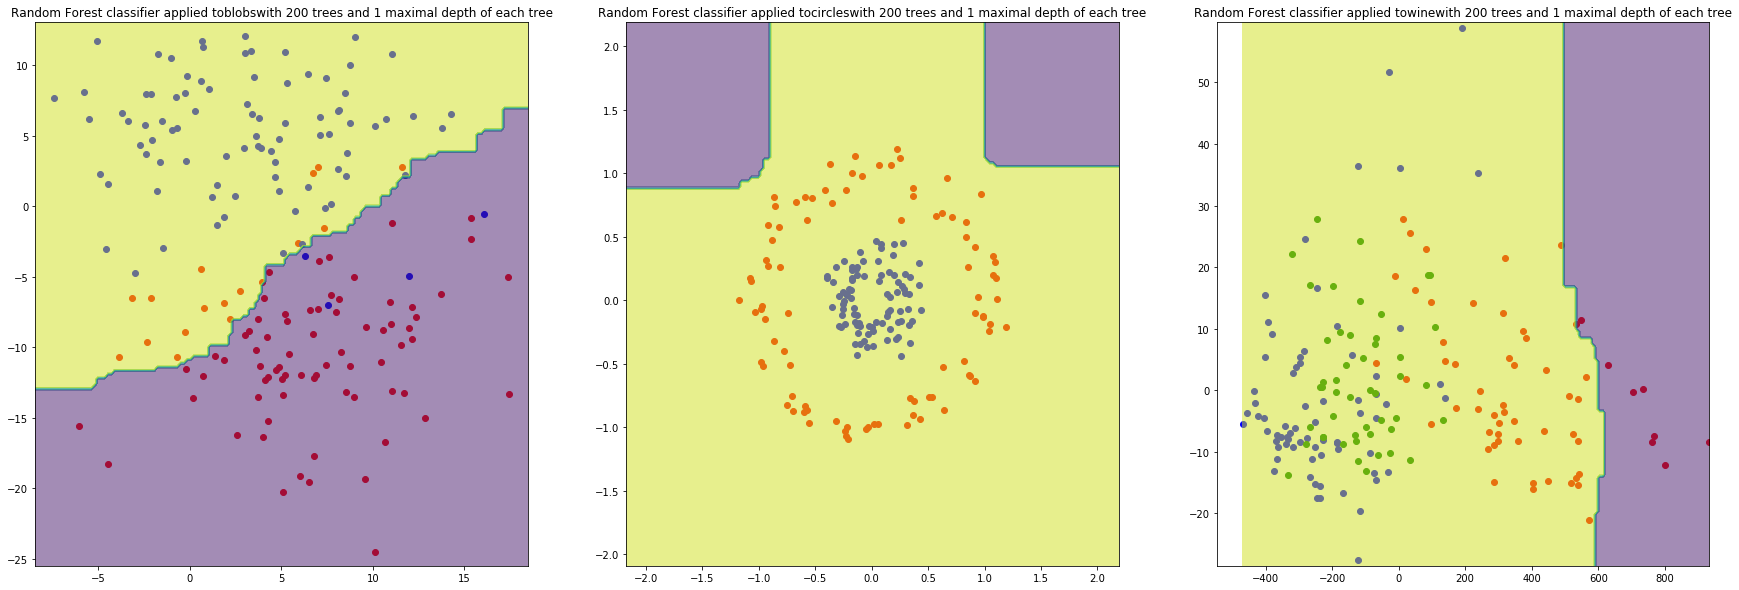

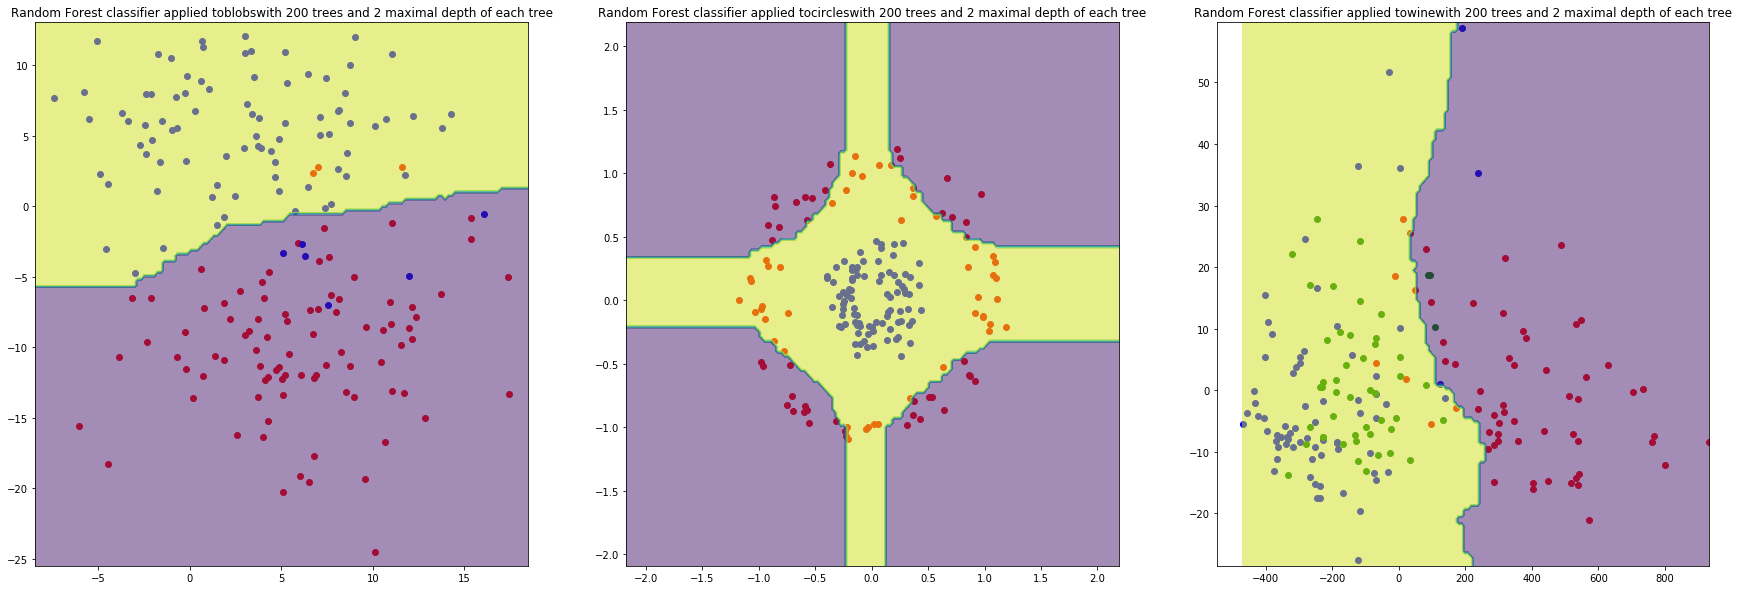

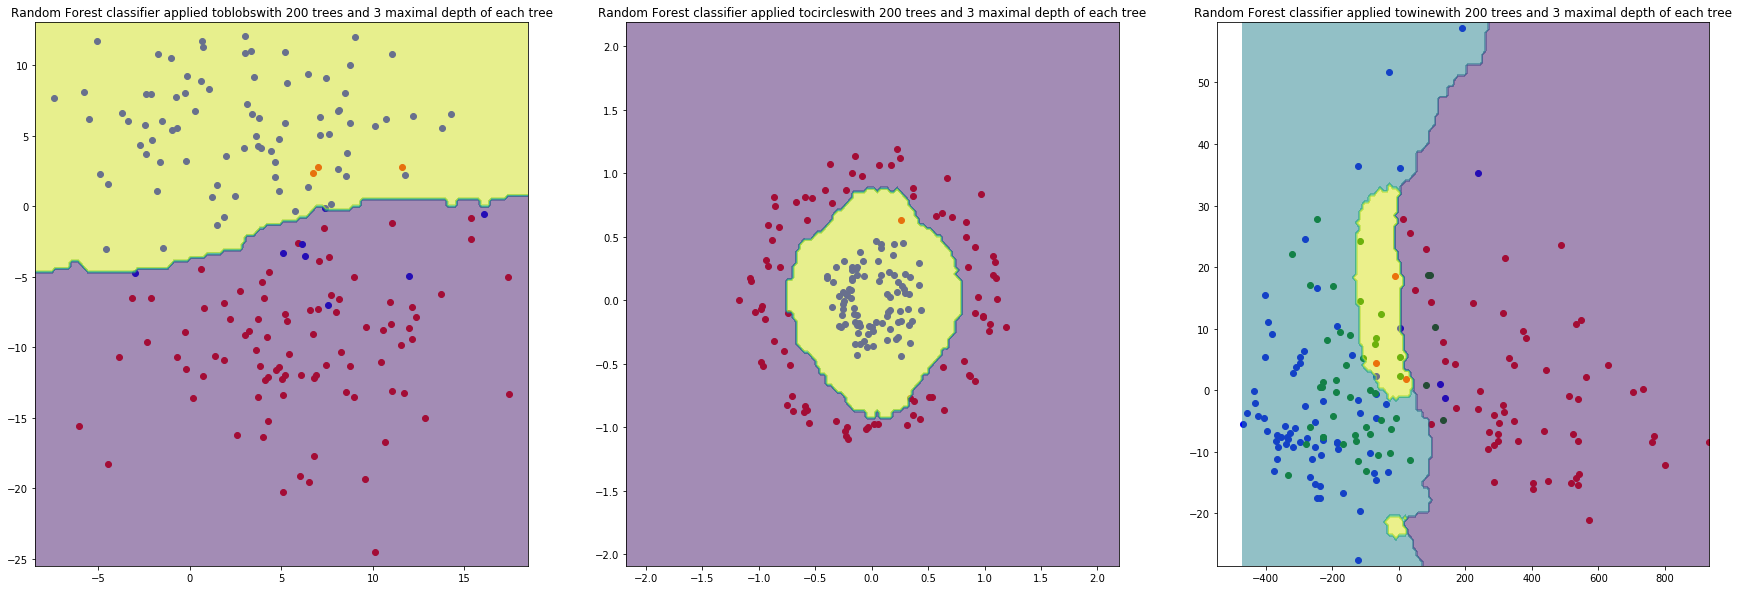

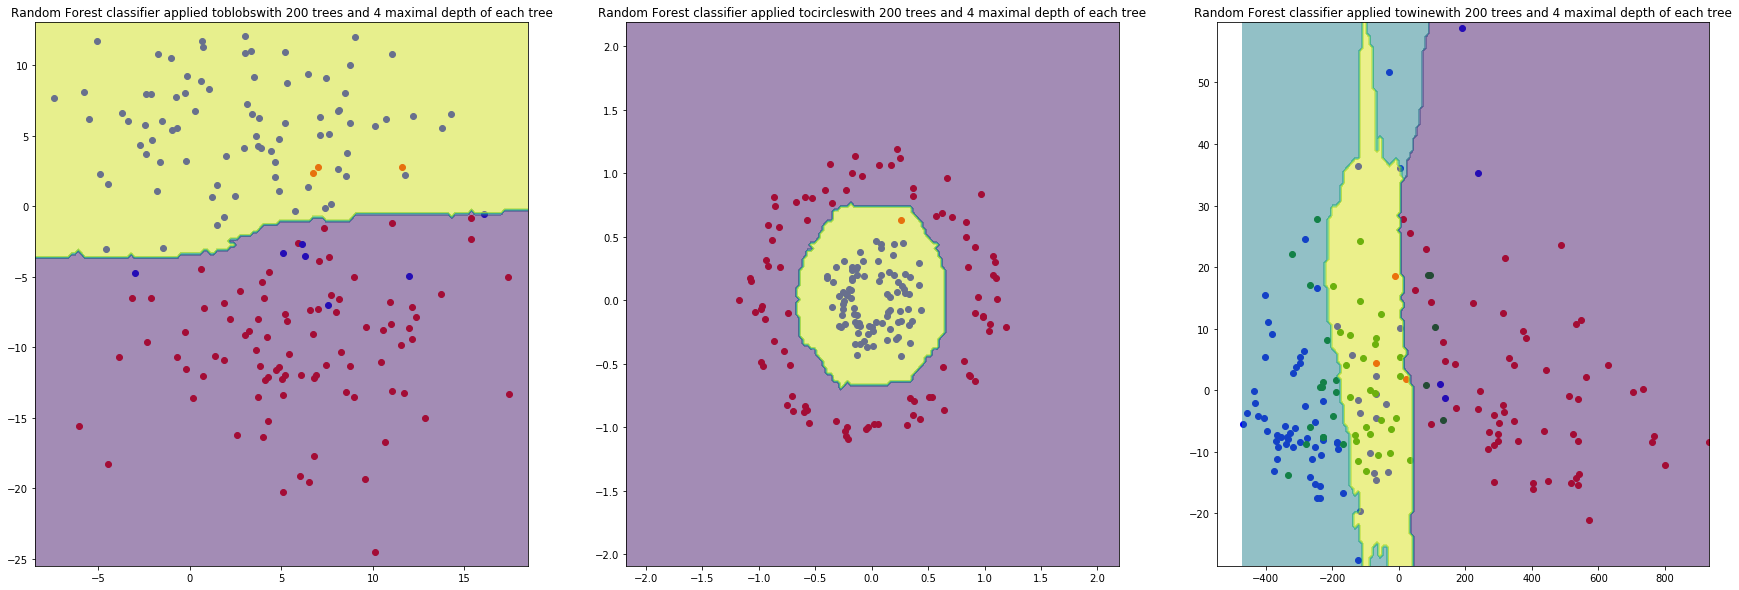

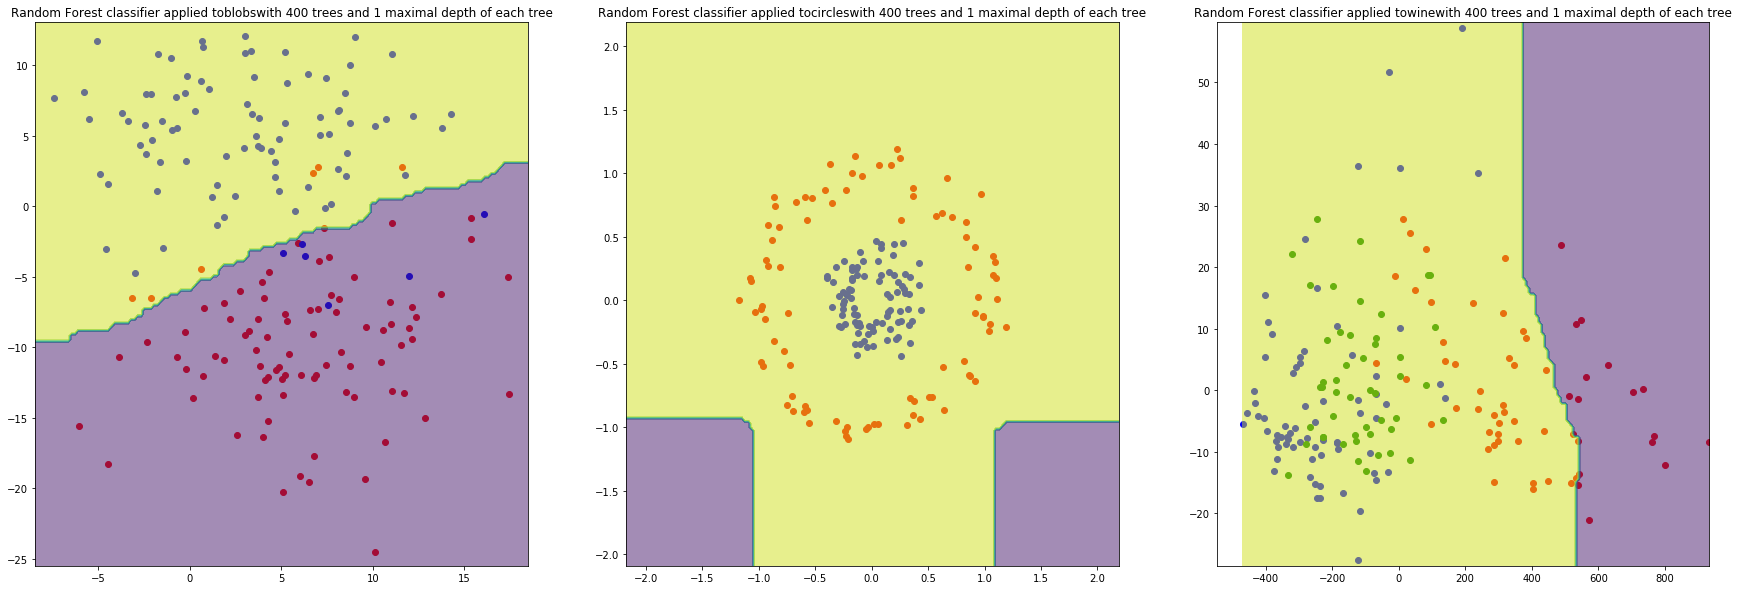

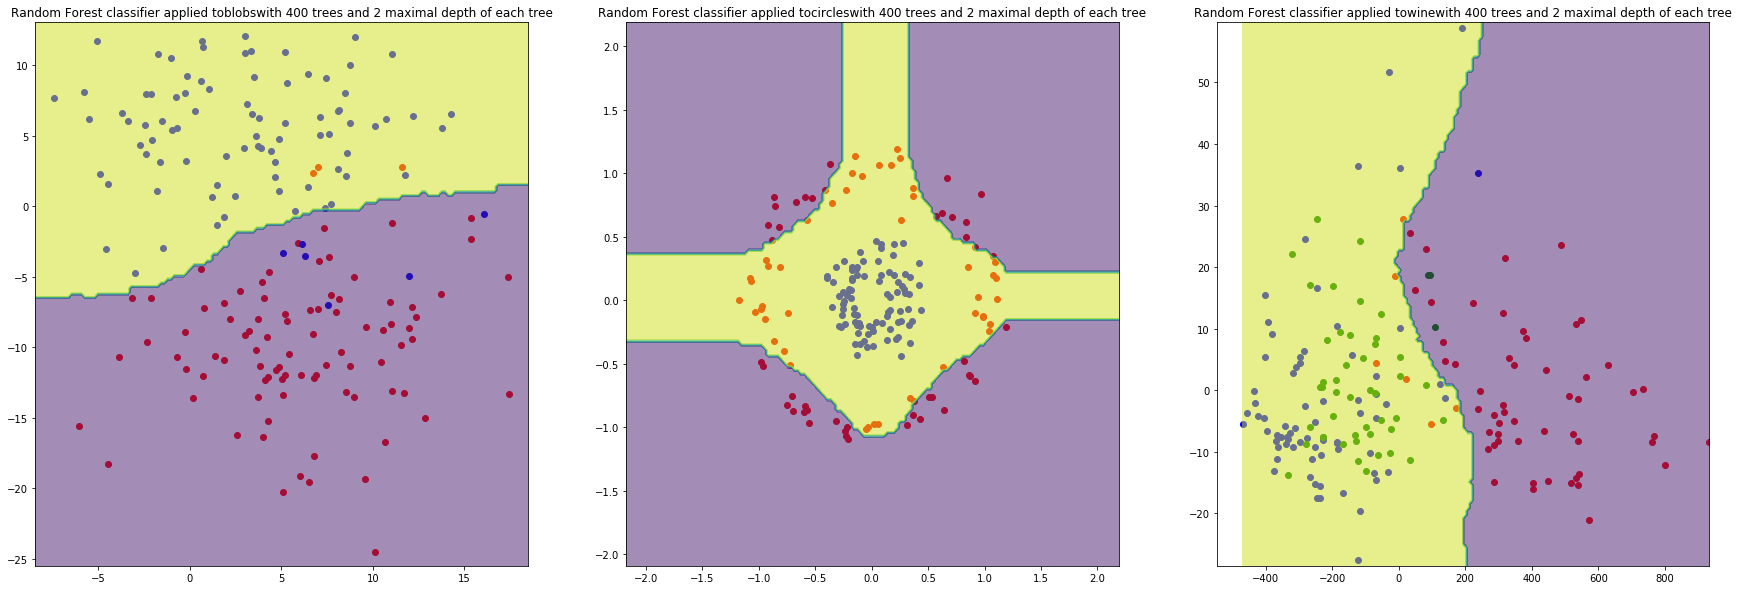

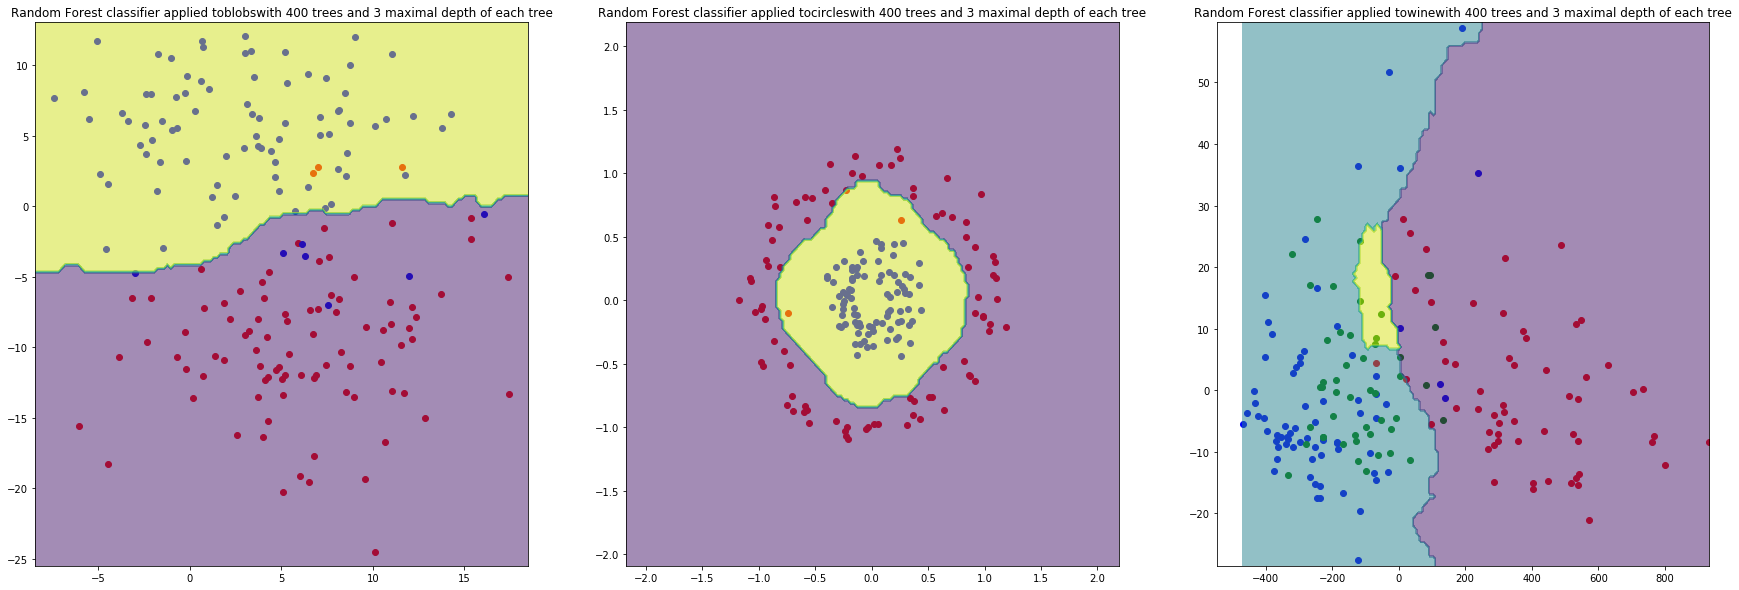

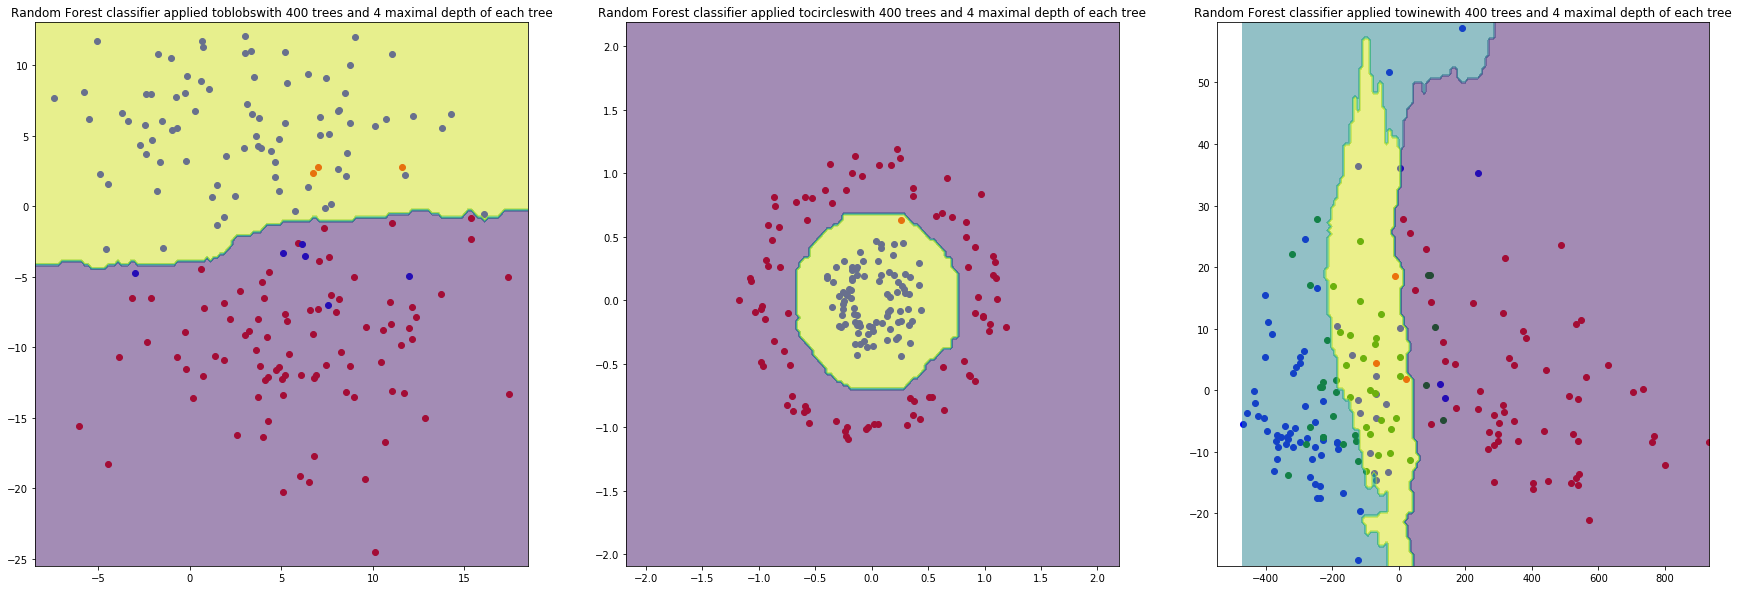

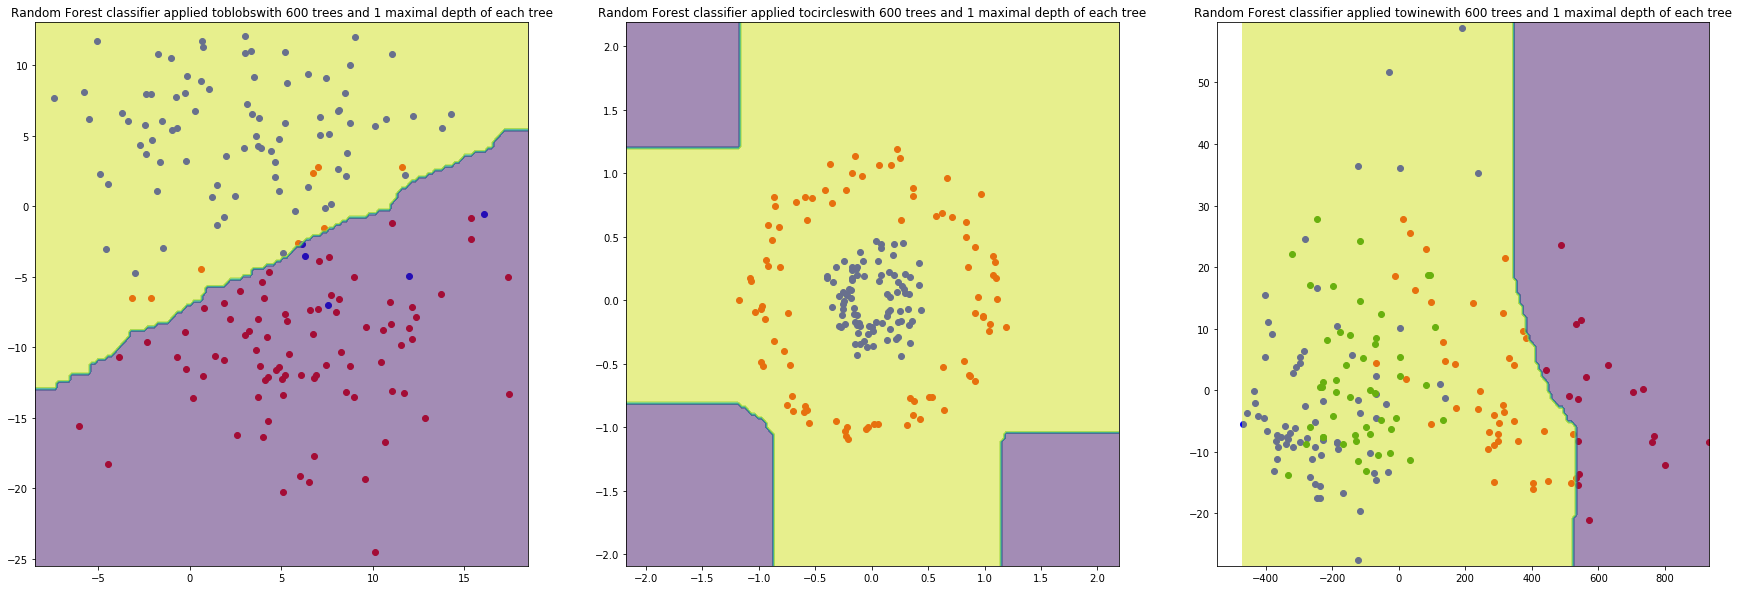

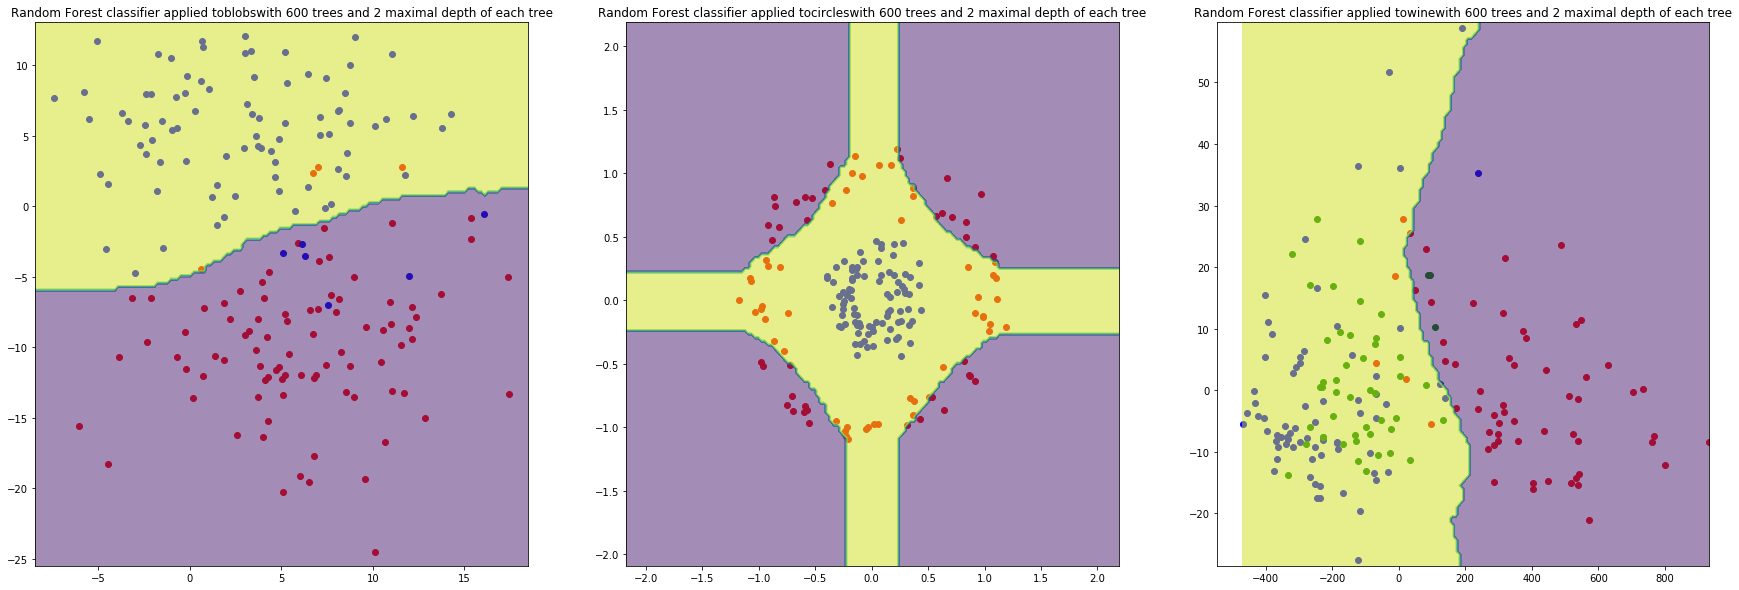

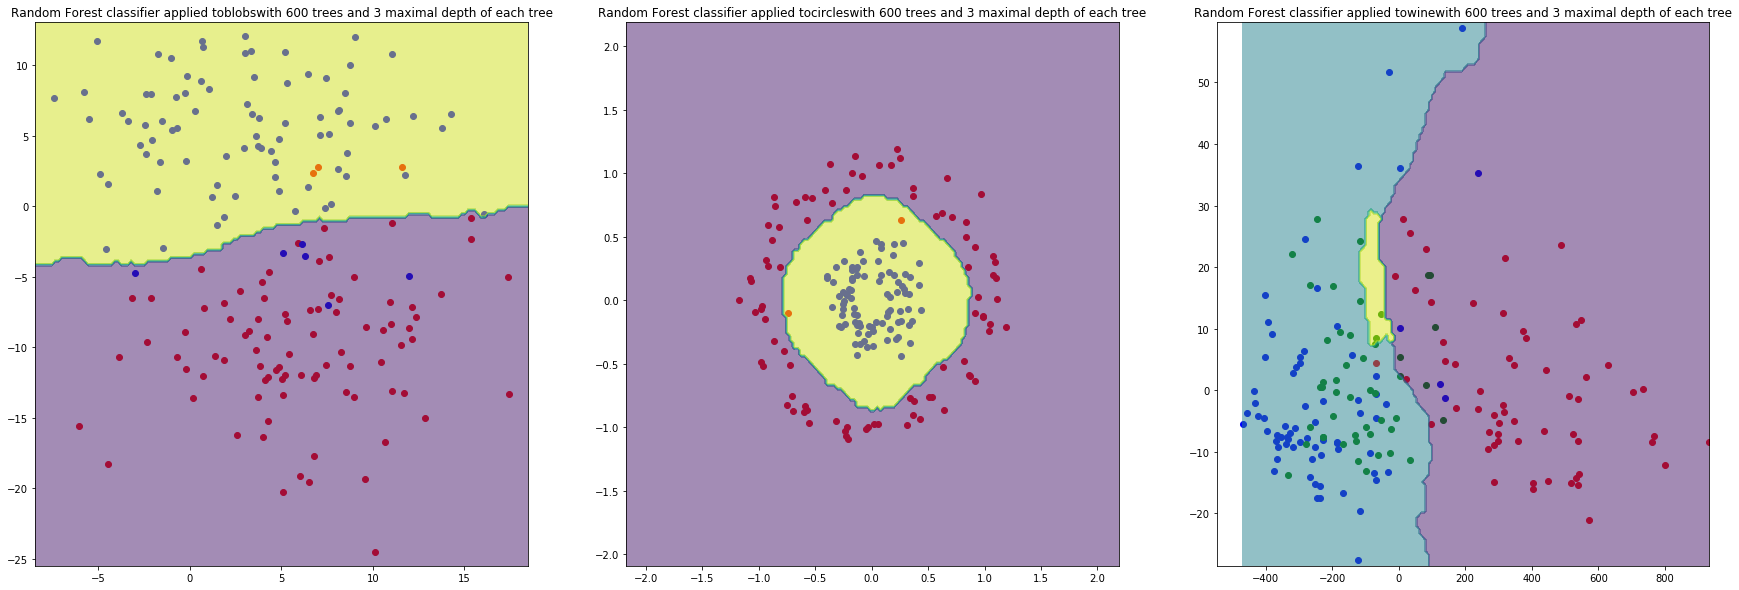

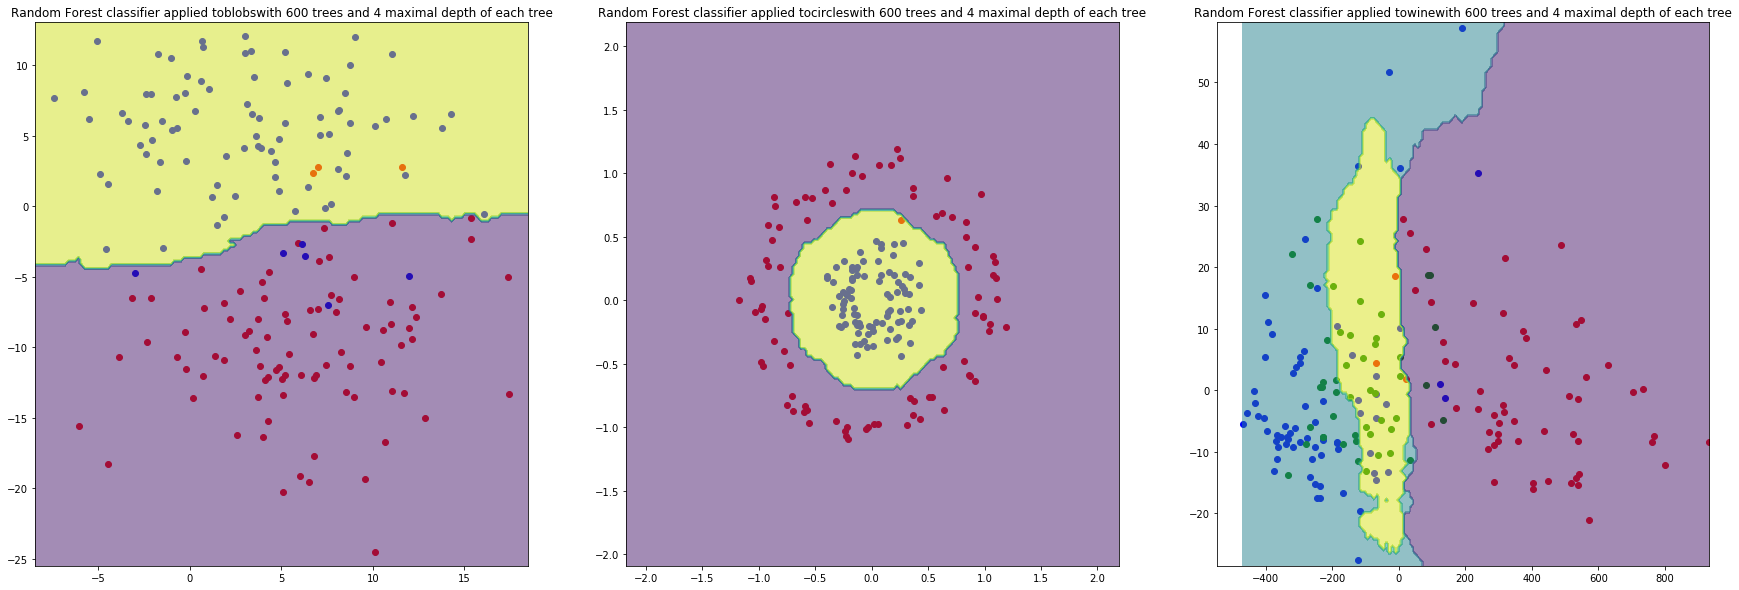

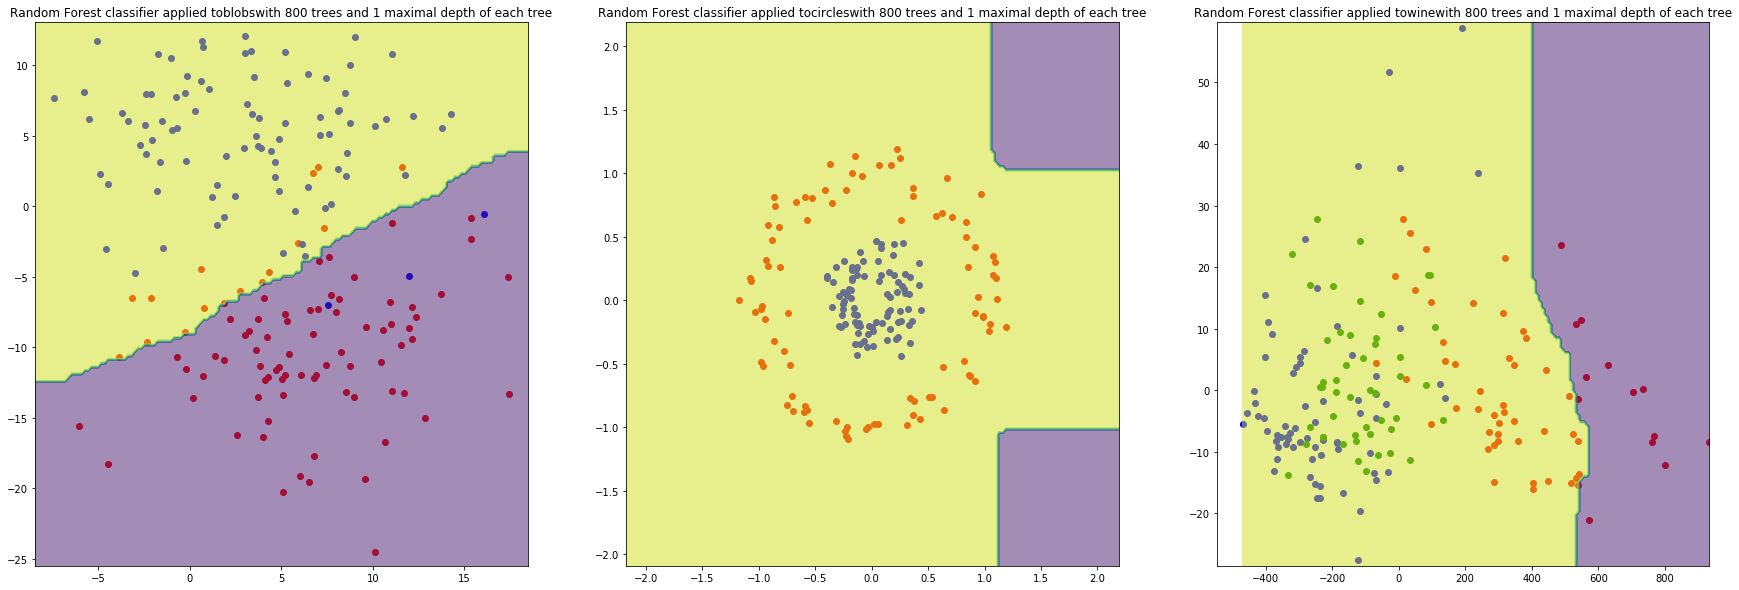

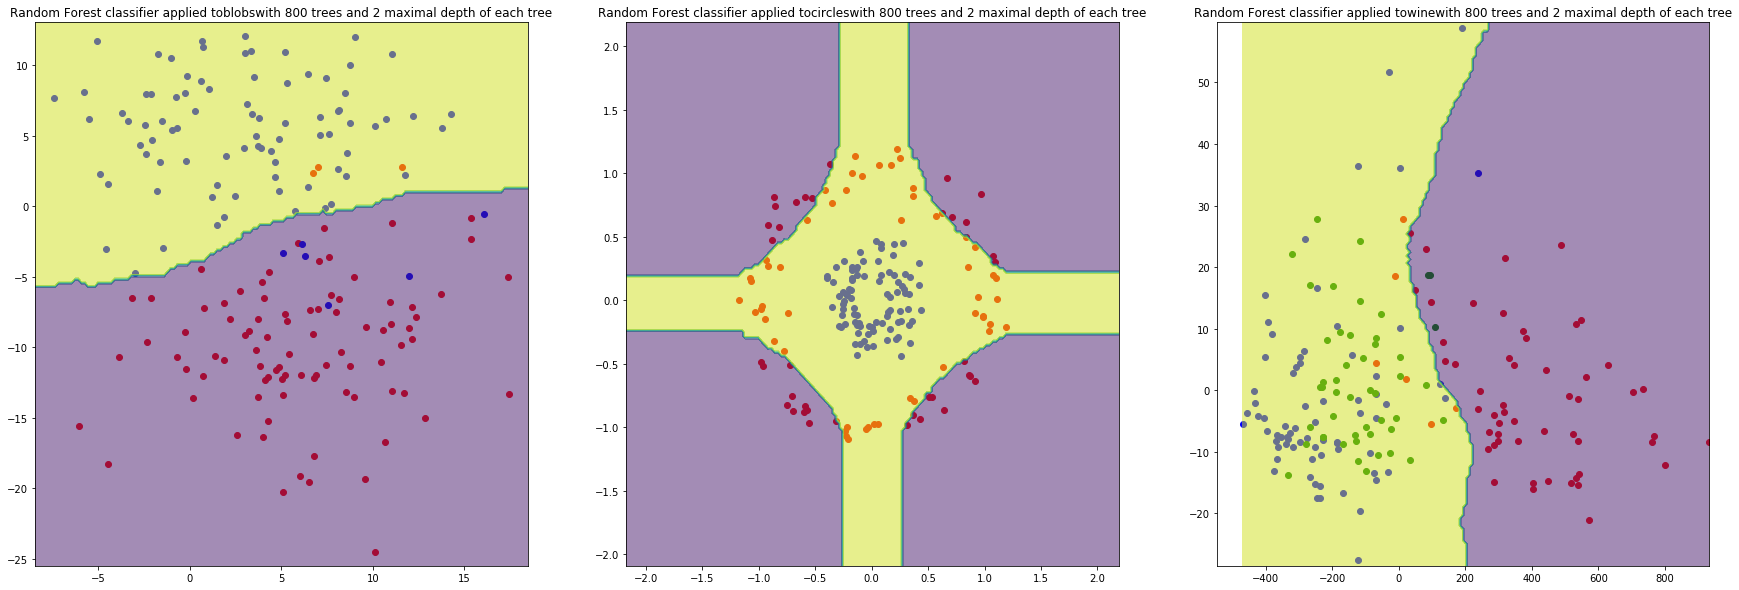

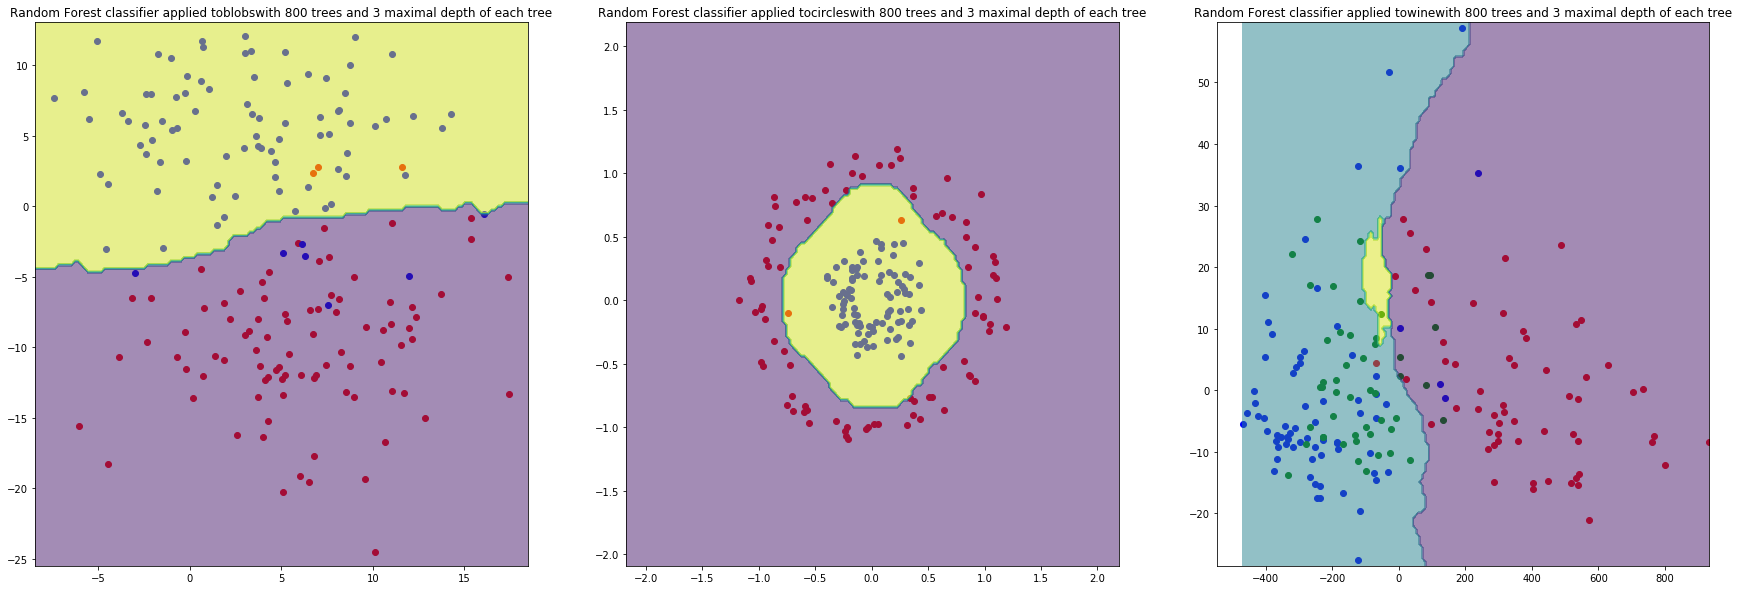

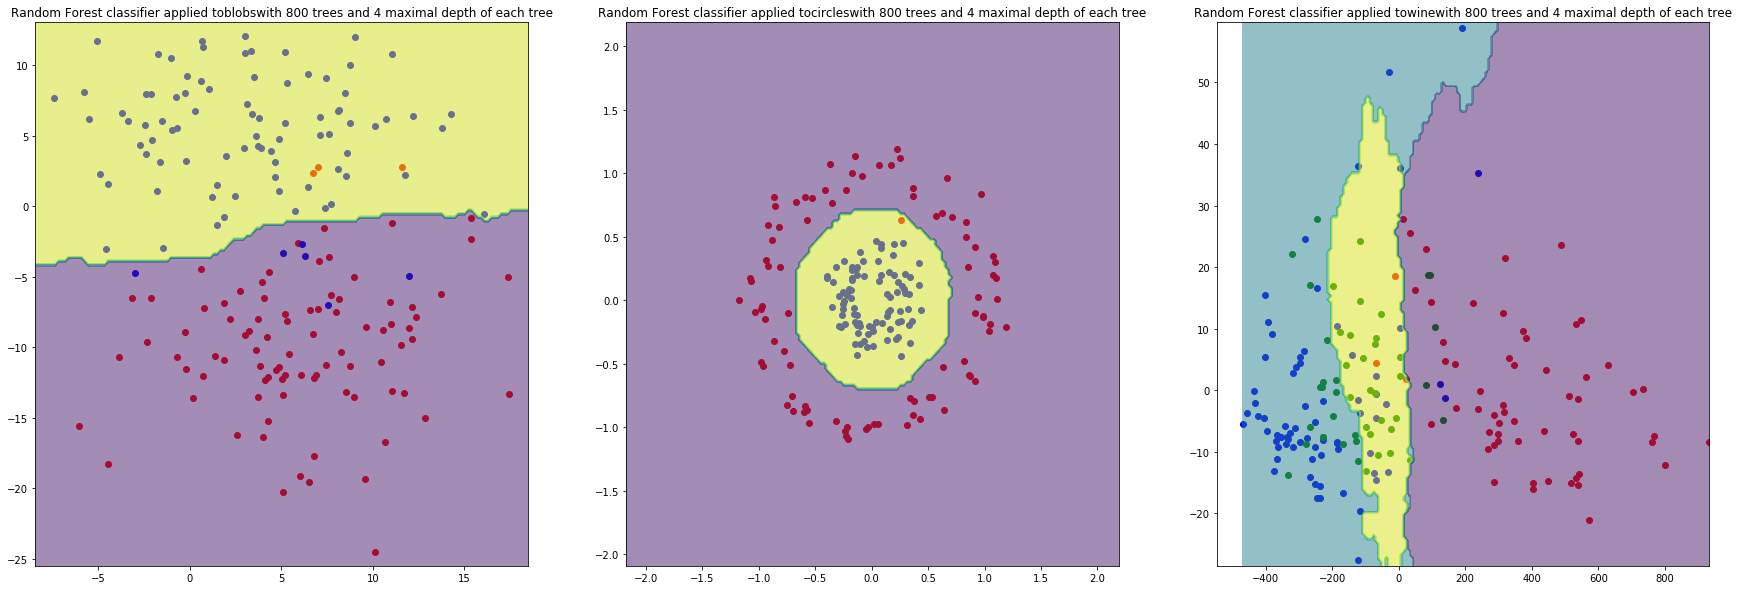

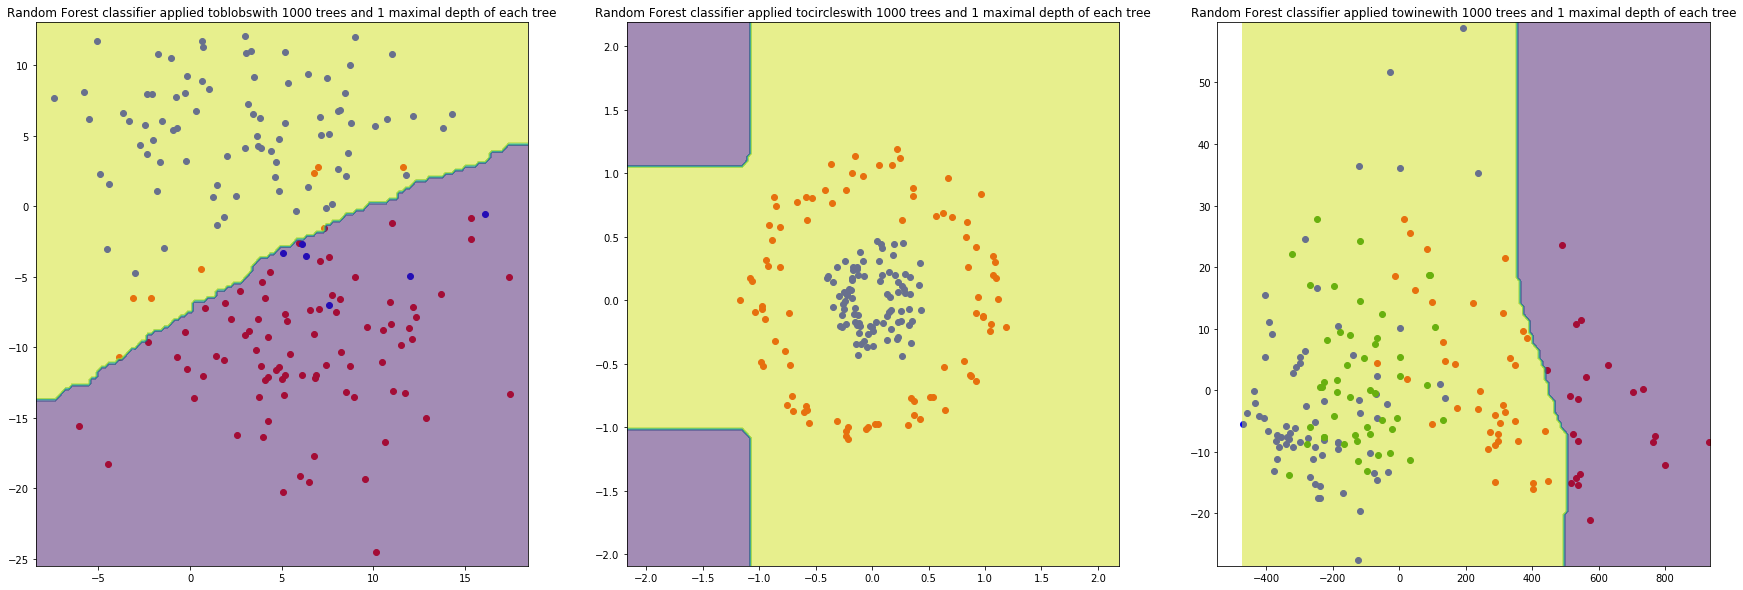

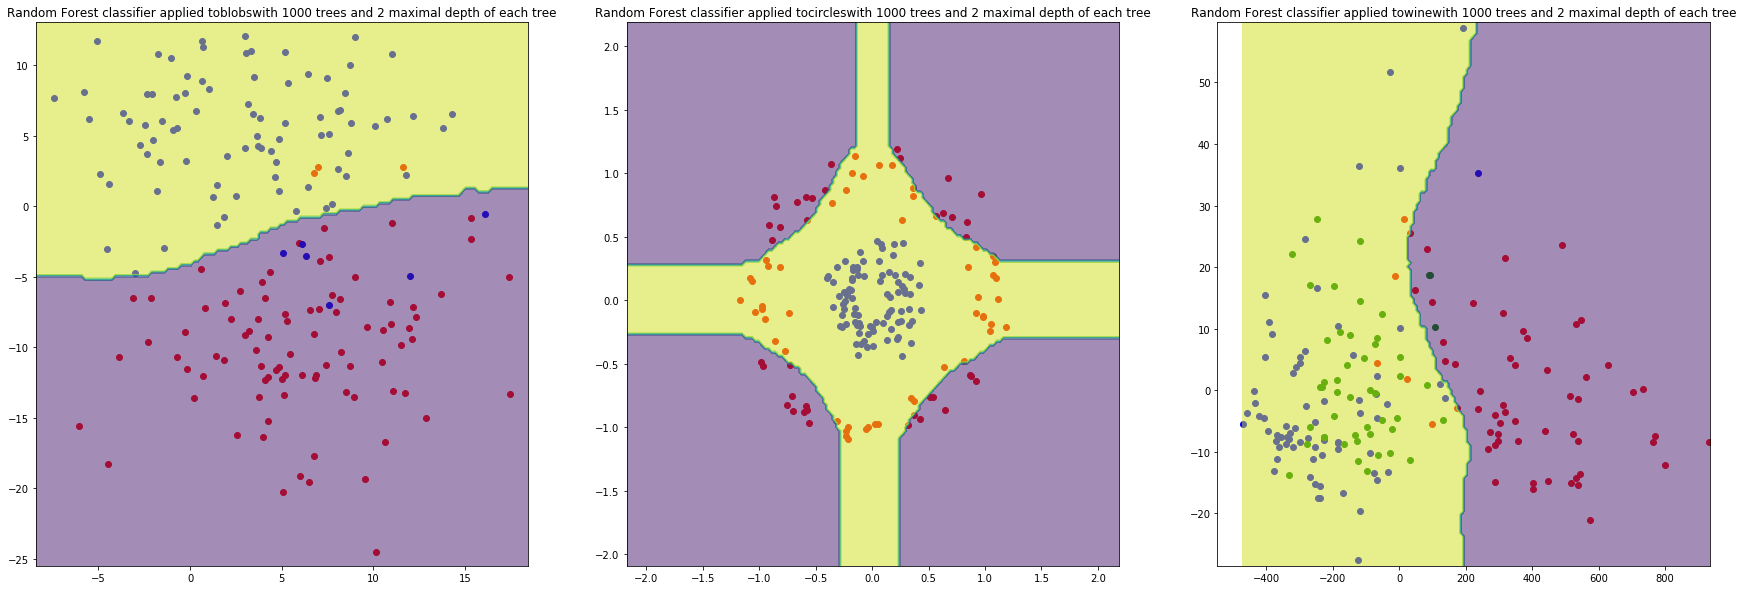

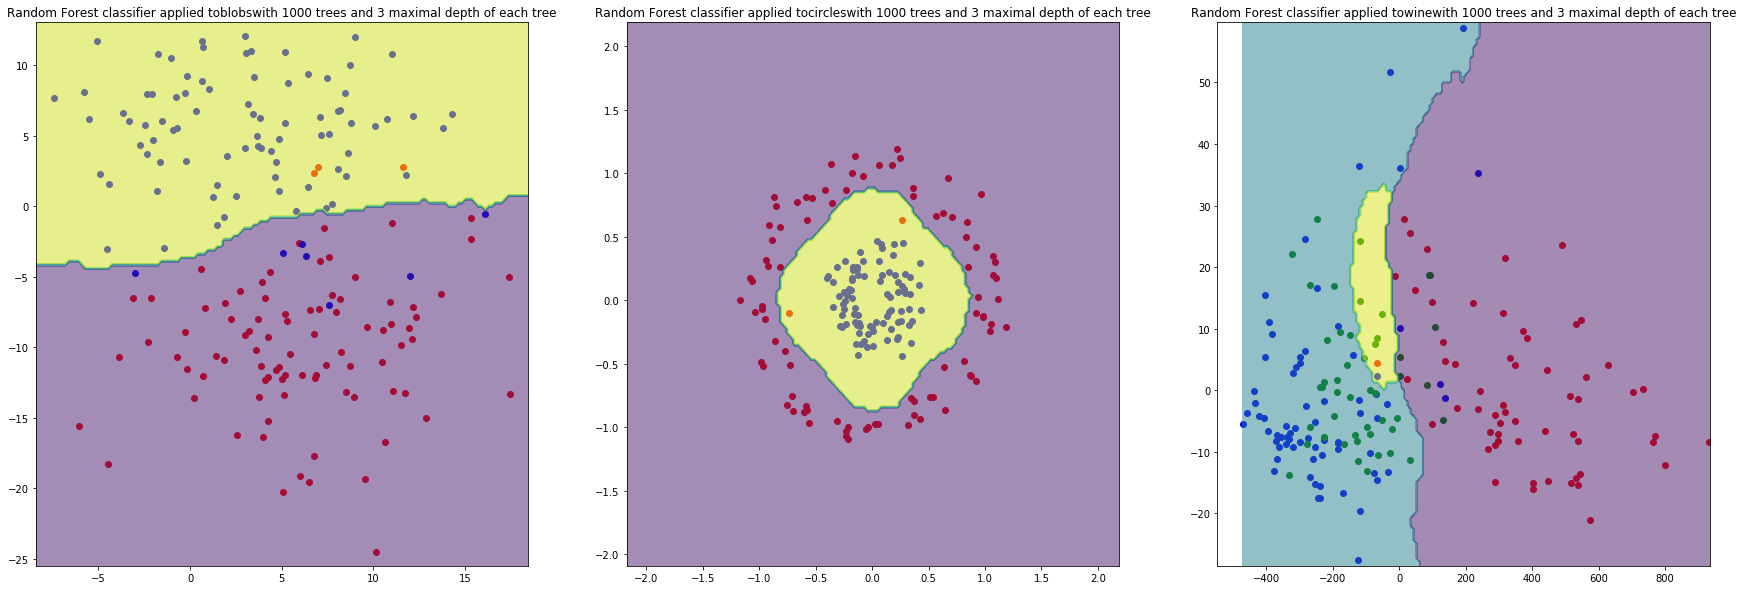

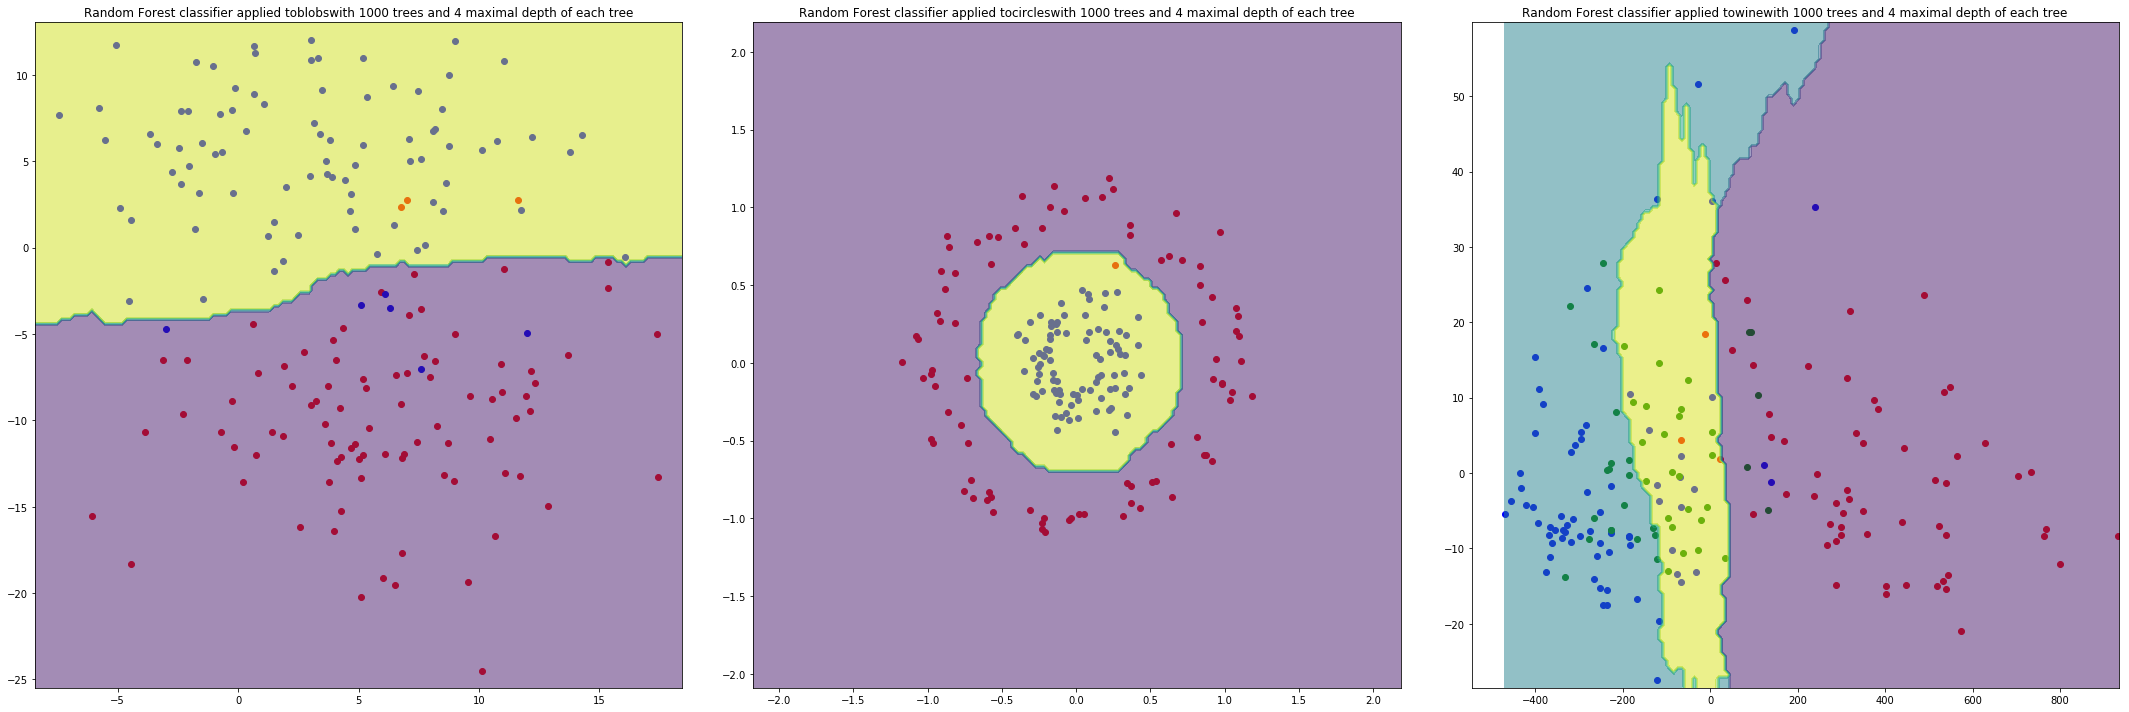

In [10]:
import random


def sampling_indices(X):
    # Draw a random number of dimensions
    d = random.randint(1, X.shape[1])
    # return indices to be sampled
    return random.sample(range(X.shape[1]), d)


def majority_vote(trees_predictions):
    return [
        max(
            [
                (cls, sum(tree_predictions == cls))
                for cls in set(tree_predictions)
            ],
            key=operator.itemgetter(-1)
        )[0]
        for tree_predictions in trees_predictions
    ]


def random_forest_train(X, Y, number_trees=100, max_depth=4):
    trees_sampling_indices = [
        (tree_idx, sampling_indices(X))
        for tree_idx in range(number_trees)
    ]
    X_as = [
        (tree_idx, X[:, sampling_indices])
        for tree_idx, sampling_indices in trees_sampling_indices
    ]
    return (
        trees_sampling_indices,
        {
            tree_idx: 
            sklearn.tree.DecisionTreeClassifier(max_depth=max_depth, splitter='random').fit(X_a, Y)
            for (tree_idx, X_a) in X_as
        }
    )


def random_forest_test(X, trees_sampling_indices, trees):
    X_as = [
        (tree_idx, X[:, sampling_indices])
        for tree_idx, sampling_indices in trees_sampling_indices
    ]
    trees_predictions = np.array(
        [
            trees[tree_idx].predict(X_a)
            for tree_idx, X_a in X_as
        ]
    ).transpose()
    return np.array(majority_vote(trees_predictions))


for n_trees, m_depth in [(200 * n, d) for n in range(1,6) for d in range(1, 5)]:
    figure, axes = plt.subplots(1, 3)
    figure.set_figheight(10)
    figure.set_figwidth(30)
    for (name, X, Y), ax, colors in zip(datasets, axes, [['r', 'b'], ['r', 'b'], ['r', 'b', 'g']]):
        plot_dataset(X, Y, ax, colors=colors)
        trees_sampling_indices, trees = random_forest_train(X, Y, number_trees=n_trees, max_depth=m_depth)
        xx, yy = mesh_from(X, 150)
        plot_separator(
            xx,
            yy,
            ax,
            lambda x:  random_forest_test(x, trees_sampling_indices, trees),
            cmap=plt.cm.viridis,
            alpha=0.5
        )
        ax.set_title(
            'Random Forest classifier applied to'
            + name
            + 'with ' + str(n_trees) + ' trees and '
            + str(m_depth) + ' maximal depth of each tree'
        )
    
plt.tight_layout()
plt.show()

#### Commentaire
* Généralement plus d'arbres il y a, et avec une profondeur qui reste faible (4), plus la forêt aléatoire sépare bien les données.
* Même avec plusieurs arbres, des arbres de profondeur 1 ou 2 reste largement insuffisants pour bien classer les deux bases de données à droite.
* Avec une méthode ensembliste, on arrive à avoir de meilleur résultats, en multipliant des classifieurs moins performants, comparés à un seul modèle trop bien calibré.